# 人脸生成（Face Generation）
在该项目中，你将使用生成式对抗网络（Generative Adversarial Nets）来生成新的人脸图像。
### 获取数据
该项目将使用以下数据集：
- MNIST
- CelebA

由于 CelebA 数据集比较复杂，而且这是你第一次使用 GANs。我们想让你先在 MNIST 数据集上测试你的 GANs 模型，以让你更快的评估所建立模型的性能。

如果你在使用 [FloydHub](https://www.floydhub.com/), 请将 `data_dir` 设置为 "/input" 并使用 [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## 探索数据（Explore the Data）
### MNIST
[MNIST](http://yann.lecun.com/exdb/mnist/) 是一个手写数字的图像数据集。你可以更改 `show_n_images` 探索此数据集。

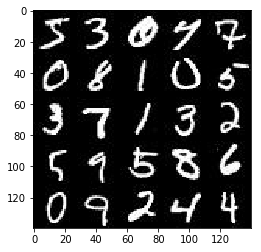

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
[CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) 是一个包含 20 多万张名人图片及相关图片说明的数据集。你将用此数据集生成人脸，不会用不到相关说明。你可以更改 `show_n_images` 探索此数据集。

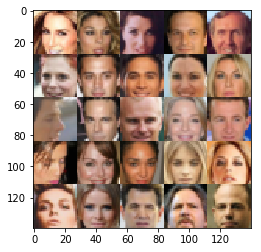

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## 预处理数据（Preprocess the Data）
由于该项目的重点是建立 GANs 模型，我们将为你预处理数据。

经过数据预处理，MNIST 和 CelebA 数据集的值在 28×28 维度图像的 [-0.5, 0.5] 范围内。CelebA 数据集中的图像裁剪了非脸部的图像部分，然后调整到 28x28 维度。

MNIST 数据集中的图像是单[通道](https://en.wikipedia.org/wiki/Channel_(digital_image%29)的黑白图像，CelebA 数据集中的图像是 [三通道的 RGB 彩色图像](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images)。

## 建立神经网络（Build the Neural Network）
你将通过部署以下函数来建立 GANs 的主要组成部分:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### 检查 TensorFlow 版本并获取 GPU 型号
检查你是否使用正确的 TensorFlow 版本，并获取 GPU 型号

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### 输入（Input）
部署 `model_inputs` 函数以创建用于神经网络的 [占位符 (TF Placeholders)](https://www.tensorflow.org/versions/r0.11/api_docs/python/io_ops/placeholders)。请创建以下占位符：
- 输入图像占位符: 使用 `image_width`，`image_height` 和 `image_channels` 设置为 rank 4。
- 输入 Z 占位符: 设置为 rank 2，并命名为 `z_dim`。
- 学习速率占位符: 设置为 rank 0。

返回占位符元组的形状为 (tensor of real input images, tensor of z data, learning rate)。


In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='inputs_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='inputs_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### 辨别器（Discriminator）
部署 `discriminator` 函数创建辨别器神经网络以辨别 `images`。该函数应能够重复使用神经网络中的各种变量。 在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "discriminator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回形如 (tensor output of the discriminator, tensor logits of the discriminator) 的元组。

In [6]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 128, 5, strides=2, padding='same')
        x1 = tf.maximum(alpha * x1, x1)
        # 14x14x128 now
        
        x2 = tf.layers.conv2d(x1, 256, 5, strides=2, padding='same')
        # batch normalization
        x2 = tf.layers.batch_normalization(x2, training=True)
        # leaky relu
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x256 now
        
        # Flatten it
        flat = tf.reshape(x2, (-1, 7*7*256))
        logits = tf.layers.dense(flat, 1)
        output = tf.sigmoid(logits)
    
    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### 生成器（Generator）
部署 `generator` 函数以使用 `z` 生成图像。该函数应能够重复使用神经网络中的各种变量。
在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "generator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回所生成的 28 x 28 x `out_channel_dim` 维度图像。

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*256)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x256 now
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=2, padding='same')
        # 28x28xout_channel_dim now
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### 损失函数（Loss）
部署 `model_loss` 函数训练并计算 GANs 的损失。该函数应返回形如 (discriminator loss, generator loss) 的元组。

使用你已实现的函数：
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [16]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2, smooth=0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake    
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### 优化（Optimization）
部署 `model_opt` 函数实现对 GANs 的优化。使用 [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) 获取可训练的所有变量。通过变量空间名 `discriminator` 和 `generator` 来过滤变量。该函数应返回形如 (discriminator training operation, generator training operation) 的元组。

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## 训练神经网络（Neural Network Training）
### 输出显示
使用该函数可以显示生成器 (Generator) 在训练过程中的当前输出，这会帮你评估 GANs 模型的训练程度。

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### 训练
部署 `train` 函数以建立并训练 GANs 模型。记得使用以下你已完成的函数：
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

使用 `show_generator_output` 函数显示 `generator` 在训练过程中的输出。

**注意**：在每个批次 (batch) 中运行 `show_generator_output` 函数会显著增加训练时间与该 notebook 的体积。推荐每 100 批次输出一次 `generator` 的输出。 

In [ ]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, input_learning_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    show_every, print_every = 100, 20
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images = batch_images*2
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, input_learning_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, input_learning_rate: learning_rate})
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    # losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, show_n_images, input_z, data_shape[3], data_image_mode)
                
                
                
                

### MNIST
在 MNIST 上测试你的 GANs 模型。经过 2 次迭代，GANs 应该能够生成类似手写数字的图像。确保生成器 (generator) 低于辨别器 (discriminator) 的损失，或接近 0。

Epoch 1/2... Discriminator Loss: 0.4526... Generator Loss: 3.2636
Epoch 1/2... Discriminator Loss: 0.3721... Generator Loss: 3.9916
Epoch 1/2... Discriminator Loss: 0.4636... Generator Loss: 9.4372
Epoch 1/2... Discriminator Loss: 1.7116... Generator Loss: 0.6387
Epoch 1/2... Discriminator Loss: 0.7246... Generator Loss: 2.3649
Epoch 1/2... Discriminator Loss: 1.0888... Generator Loss: 3.0968
Epoch 1/2... Discriminator Loss: 0.8550... Generator Loss: 1.4207
Epoch 1/2... Discriminator Loss: 0.8389... Generator Loss: 2.4015
Epoch 1/2... Discriminator Loss: 0.9665... Generator Loss: 2.7288
Epoch 1/2... Discriminator Loss: 0.7966... Generator Loss: 1.4191


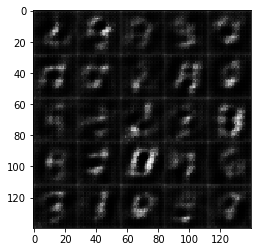

Epoch 1/2... Discriminator Loss: 1.3352... Generator Loss: 2.6697
Epoch 1/2... Discriminator Loss: 1.1435... Generator Loss: 0.8472
Epoch 1/2... Discriminator Loss: 1.6276... Generator Loss: 0.4035
Epoch 1/2... Discriminator Loss: 1.3018... Generator Loss: 0.5851
Epoch 1/2... Discriminator Loss: 1.2485... Generator Loss: 0.6586
Epoch 1/2... Discriminator Loss: 1.2837... Generator Loss: 0.6738
Epoch 1/2... Discriminator Loss: 1.0732... Generator Loss: 0.9310
Epoch 1/2... Discriminator Loss: 1.2121... Generator Loss: 1.3492
Epoch 1/2... Discriminator Loss: 1.1614... Generator Loss: 0.8056
Epoch 1/2... Discriminator Loss: 1.0911... Generator Loss: 1.0320


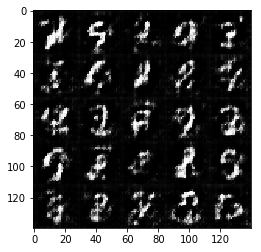

Epoch 1/2... Discriminator Loss: 1.1945... Generator Loss: 1.8207
Epoch 1/2... Discriminator Loss: 1.0286... Generator Loss: 1.4899
Epoch 1/2... Discriminator Loss: 1.2492... Generator Loss: 0.6458
Epoch 1/2... Discriminator Loss: 1.0558... Generator Loss: 0.9273
Epoch 1/2... Discriminator Loss: 1.0711... Generator Loss: 1.6468
Epoch 1/2... Discriminator Loss: 0.9786... Generator Loss: 1.4117
Epoch 1/2... Discriminator Loss: 0.8571... Generator Loss: 1.4910
Epoch 1/2... Discriminator Loss: 1.3764... Generator Loss: 0.5673
Epoch 1/2... Discriminator Loss: 0.9843... Generator Loss: 1.8933
Epoch 1/2... Discriminator Loss: 1.1500... Generator Loss: 0.7081


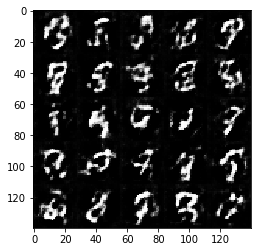

Epoch 1/2... Discriminator Loss: 1.1446... Generator Loss: 0.6846
Epoch 1/2... Discriminator Loss: 0.8966... Generator Loss: 1.3084
Epoch 1/2... Discriminator Loss: 1.0672... Generator Loss: 0.8387
Epoch 1/2... Discriminator Loss: 1.0063... Generator Loss: 1.1310
Epoch 1/2... Discriminator Loss: 1.0246... Generator Loss: 2.1530
Epoch 1/2... Discriminator Loss: 0.9989... Generator Loss: 0.9114
Epoch 1/2... Discriminator Loss: 1.2048... Generator Loss: 2.8648
Epoch 1/2... Discriminator Loss: 0.9199... Generator Loss: 1.0842
Epoch 1/2... Discriminator Loss: 1.1274... Generator Loss: 0.9228
Epoch 1/2... Discriminator Loss: 1.0872... Generator Loss: 0.7856


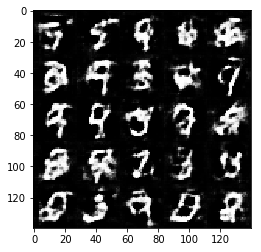

Epoch 1/2... Discriminator Loss: 1.2736... Generator Loss: 2.5215
Epoch 1/2... Discriminator Loss: 1.2391... Generator Loss: 0.6488
Epoch 1/2... Discriminator Loss: 1.0387... Generator Loss: 1.3966
Epoch 1/2... Discriminator Loss: 0.9528... Generator Loss: 1.0727
Epoch 1/2... Discriminator Loss: 1.2929... Generator Loss: 2.7042
Epoch 1/2... Discriminator Loss: 1.0542... Generator Loss: 0.8369
Epoch 2/2... Discriminator Loss: 1.2849... Generator Loss: 1.7220
Epoch 2/2... Discriminator Loss: 1.0236... Generator Loss: 1.5965
Epoch 2/2... Discriminator Loss: 0.9420... Generator Loss: 1.1434
Epoch 2/2... Discriminator Loss: 1.1928... Generator Loss: 0.6673


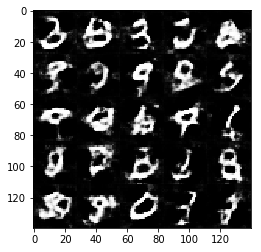

Epoch 2/2... Discriminator Loss: 0.8450... Generator Loss: 1.3673
Epoch 2/2... Discriminator Loss: 1.1021... Generator Loss: 0.8470
Epoch 2/2... Discriminator Loss: 1.0856... Generator Loss: 1.5286
Epoch 2/2... Discriminator Loss: 1.7194... Generator Loss: 0.3475
Epoch 2/2... Discriminator Loss: 1.1713... Generator Loss: 1.6229
Epoch 2/2... Discriminator Loss: 1.0431... Generator Loss: 1.6939
Epoch 2/2... Discriminator Loss: 0.9889... Generator Loss: 0.9815
Epoch 2/2... Discriminator Loss: 1.1262... Generator Loss: 1.5094
Epoch 2/2... Discriminator Loss: 1.2191... Generator Loss: 0.6702
Epoch 2/2... Discriminator Loss: 0.9913... Generator Loss: 1.2342


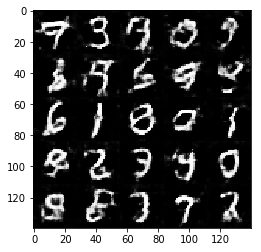

Epoch 2/2... Discriminator Loss: 1.0335... Generator Loss: 0.9089
Epoch 2/2... Discriminator Loss: 0.9761... Generator Loss: 1.3507
Epoch 2/2... Discriminator Loss: 1.1274... Generator Loss: 1.5949
Epoch 2/2... Discriminator Loss: 1.1425... Generator Loss: 0.8880
Epoch 2/2... Discriminator Loss: 0.9937... Generator Loss: 1.1640
Epoch 2/2... Discriminator Loss: 1.2426... Generator Loss: 0.6984
Epoch 2/2... Discriminator Loss: 1.0904... Generator Loss: 1.1627
Epoch 2/2... Discriminator Loss: 1.0474... Generator Loss: 0.9033
Epoch 2/2... Discriminator Loss: 0.9192... Generator Loss: 1.4070
Epoch 2/2... Discriminator Loss: 1.4425... Generator Loss: 0.5613


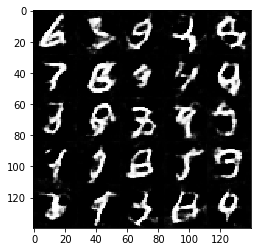

Epoch 2/2... Discriminator Loss: 1.1554... Generator Loss: 0.9845
Epoch 2/2... Discriminator Loss: 0.8876... Generator Loss: 1.4270
Epoch 2/2... Discriminator Loss: 1.3646... Generator Loss: 1.7679
Epoch 2/2... Discriminator Loss: 1.0347... Generator Loss: 0.9777
Epoch 2/2... Discriminator Loss: 1.2996... Generator Loss: 0.6279
Epoch 2/2... Discriminator Loss: 1.1914... Generator Loss: 1.9933
Epoch 2/2... Discriminator Loss: 1.1649... Generator Loss: 0.7933
Epoch 2/2... Discriminator Loss: 1.0285... Generator Loss: 0.9492
Epoch 2/2... Discriminator Loss: 1.4527... Generator Loss: 0.4693
Epoch 2/2... Discriminator Loss: 1.1710... Generator Loss: 0.8452


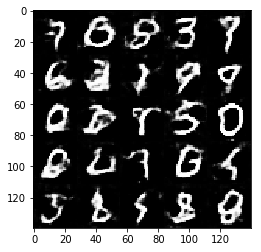

Epoch 2/2... Discriminator Loss: 1.3120... Generator Loss: 1.1986
Epoch 2/2... Discriminator Loss: 1.0143... Generator Loss: 1.6214
Epoch 2/2... Discriminator Loss: 1.1395... Generator Loss: 0.7771
Epoch 2/2... Discriminator Loss: 1.0092... Generator Loss: 1.2656
Epoch 2/2... Discriminator Loss: 1.2476... Generator Loss: 0.6101
Epoch 2/2... Discriminator Loss: 1.5734... Generator Loss: 0.4215
Epoch 2/2... Discriminator Loss: 1.2170... Generator Loss: 1.1476
Epoch 2/2... Discriminator Loss: 1.0550... Generator Loss: 1.5000
Epoch 2/2... Discriminator Loss: 0.9557... Generator Loss: 1.4850
Epoch 2/2... Discriminator Loss: 1.9044... Generator Loss: 3.2125


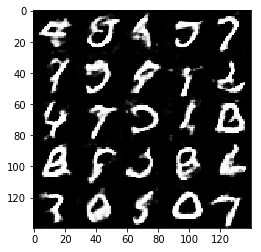

Epoch 2/2... Discriminator Loss: 1.6681... Generator Loss: 0.3986
Epoch 2/2... Discriminator Loss: 1.0308... Generator Loss: 1.3049
Epoch 2/2... Discriminator Loss: 0.8687... Generator Loss: 1.4347


In [24]:
batch_size = 128
z_dim = 200
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
在 CelebA 上运行你的 GANs 模型。在一般的GPU上运行每次迭代大约需要 20 分钟。你可以运行整个迭代，或者当 GANs 开始产生真实人脸图像时停止它。

Epoch 1/10... Discriminator Loss: 0.4992... Generator Loss: 5.0606
Epoch 1/10... Discriminator Loss: 0.5927... Generator Loss: 2.3047
Epoch 1/10... Discriminator Loss: 1.4671... Generator Loss: 14.6914
Epoch 1/10... Discriminator Loss: 0.9649... Generator Loss: 1.9070
Epoch 1/10... Discriminator Loss: 1.1341... Generator Loss: 1.0984
Epoch 1/10... Discriminator Loss: 1.7208... Generator Loss: 2.8548
Epoch 1/10... Discriminator Loss: 1.1414... Generator Loss: 1.4263
Epoch 1/10... Discriminator Loss: 0.8908... Generator Loss: 1.3309
Epoch 1/10... Discriminator Loss: 1.1123... Generator Loss: 0.7839
Epoch 1/10... Discriminator Loss: 0.8402... Generator Loss: 1.2256


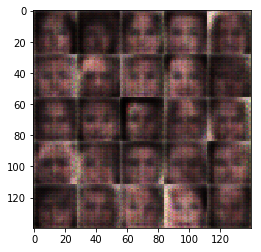

Epoch 1/10... Discriminator Loss: 1.2439... Generator Loss: 0.8067
Epoch 1/10... Discriminator Loss: 0.9177... Generator Loss: 1.7718
Epoch 1/10... Discriminator Loss: 2.1953... Generator Loss: 0.2410
Epoch 1/10... Discriminator Loss: 1.1938... Generator Loss: 2.7888
Epoch 1/10... Discriminator Loss: 1.7348... Generator Loss: 0.6390
Epoch 1/10... Discriminator Loss: 1.2317... Generator Loss: 2.1932
Epoch 1/10... Discriminator Loss: 1.2469... Generator Loss: 0.6954
Epoch 1/10... Discriminator Loss: 0.5729... Generator Loss: 2.7343
Epoch 1/10... Discriminator Loss: 1.0554... Generator Loss: 0.8155
Epoch 1/10... Discriminator Loss: 0.8786... Generator Loss: 2.2554


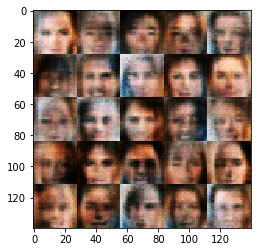

Epoch 1/10... Discriminator Loss: 1.1141... Generator Loss: 5.5507
Epoch 1/10... Discriminator Loss: 0.6322... Generator Loss: 3.3406
Epoch 1/10... Discriminator Loss: 1.2861... Generator Loss: 2.2667
Epoch 1/10... Discriminator Loss: 1.6914... Generator Loss: 0.3772
Epoch 1/10... Discriminator Loss: 0.5494... Generator Loss: 3.1635
Epoch 1/10... Discriminator Loss: 0.7139... Generator Loss: 1.3501
Epoch 1/10... Discriminator Loss: 1.2911... Generator Loss: 7.8100
Epoch 1/10... Discriminator Loss: 1.0019... Generator Loss: 1.1674
Epoch 1/10... Discriminator Loss: 0.3994... Generator Loss: 3.2739
Epoch 1/10... Discriminator Loss: 0.4426... Generator Loss: 3.0439


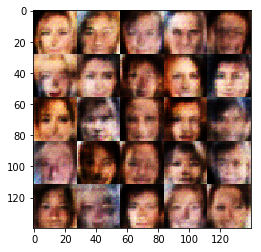

Epoch 1/10... Discriminator Loss: 0.7781... Generator Loss: 1.2520
Epoch 1/10... Discriminator Loss: 1.2018... Generator Loss: 0.6496
Epoch 1/10... Discriminator Loss: 0.7114... Generator Loss: 7.2334
Epoch 1/10... Discriminator Loss: 0.5740... Generator Loss: 2.5780
Epoch 1/10... Discriminator Loss: 0.8652... Generator Loss: 1.6010
Epoch 1/10... Discriminator Loss: 0.4875... Generator Loss: 3.7537
Epoch 1/10... Discriminator Loss: 0.6468... Generator Loss: 1.8461
Epoch 1/10... Discriminator Loss: 2.0091... Generator Loss: 0.2364
Epoch 1/10... Discriminator Loss: 0.5751... Generator Loss: 6.8729
Epoch 1/10... Discriminator Loss: 0.4027... Generator Loss: 4.4567


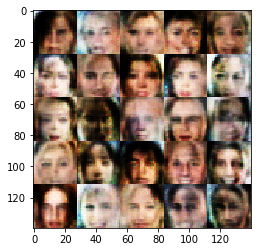

Epoch 1/10... Discriminator Loss: 0.3618... Generator Loss: 5.4750
Epoch 1/10... Discriminator Loss: 0.4666... Generator Loss: 3.2926
Epoch 1/10... Discriminator Loss: 0.3950... Generator Loss: 6.9168
Epoch 1/10... Discriminator Loss: 0.4271... Generator Loss: 5.6507
Epoch 1/10... Discriminator Loss: 0.5789... Generator Loss: 2.5664
Epoch 1/10... Discriminator Loss: 0.7160... Generator Loss: 1.6848
Epoch 1/10... Discriminator Loss: 0.4186... Generator Loss: 3.8348
Epoch 1/10... Discriminator Loss: 0.6481... Generator Loss: 2.8717
Epoch 1/10... Discriminator Loss: 0.7278... Generator Loss: 1.7753
Epoch 1/10... Discriminator Loss: 0.4255... Generator Loss: 8.0260


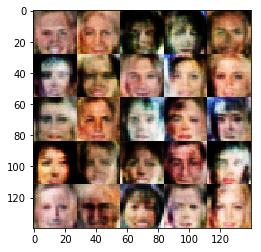

Epoch 1/10... Discriminator Loss: 0.8712... Generator Loss: 1.5749
Epoch 1/10... Discriminator Loss: 0.8135... Generator Loss: 1.2110
Epoch 1/10... Discriminator Loss: 0.3978... Generator Loss: 5.6494
Epoch 1/10... Discriminator Loss: 0.5327... Generator Loss: 2.4797
Epoch 1/10... Discriminator Loss: 0.4301... Generator Loss: 4.4773
Epoch 1/10... Discriminator Loss: 0.7688... Generator Loss: 1.7510
Epoch 1/10... Discriminator Loss: 0.4803... Generator Loss: 2.9959
Epoch 1/10... Discriminator Loss: 0.4078... Generator Loss: 3.2833
Epoch 1/10... Discriminator Loss: 0.6719... Generator Loss: 5.1611
Epoch 1/10... Discriminator Loss: 0.9041... Generator Loss: 1.6742


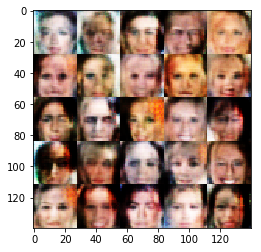

Epoch 1/10... Discriminator Loss: 0.3781... Generator Loss: 4.9621
Epoch 1/10... Discriminator Loss: 1.0235... Generator Loss: 1.4645
Epoch 1/10... Discriminator Loss: 4.2708... Generator Loss: 3.4160
Epoch 1/10... Discriminator Loss: 1.6211... Generator Loss: 2.1572
Epoch 1/10... Discriminator Loss: 1.3579... Generator Loss: 0.6376
Epoch 1/10... Discriminator Loss: 1.1198... Generator Loss: 1.1581
Epoch 1/10... Discriminator Loss: 1.1777... Generator Loss: 1.0762
Epoch 1/10... Discriminator Loss: 1.2809... Generator Loss: 1.0131
Epoch 1/10... Discriminator Loss: 1.1780... Generator Loss: 1.2314
Epoch 1/10... Discriminator Loss: 0.8195... Generator Loss: 1.6569


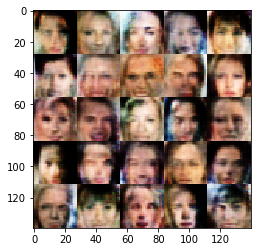

Epoch 1/10... Discriminator Loss: 1.3516... Generator Loss: 2.8172
Epoch 1/10... Discriminator Loss: 0.7217... Generator Loss: 2.2447
Epoch 1/10... Discriminator Loss: 0.6578... Generator Loss: 1.9162
Epoch 1/10... Discriminator Loss: 0.6303... Generator Loss: 2.1688
Epoch 1/10... Discriminator Loss: 0.5108... Generator Loss: 6.1702
Epoch 1/10... Discriminator Loss: 0.7062... Generator Loss: 1.5683
Epoch 1/10... Discriminator Loss: 0.8422... Generator Loss: 1.1340
Epoch 1/10... Discriminator Loss: 0.4607... Generator Loss: 4.6951
Epoch 1/10... Discriminator Loss: 0.4425... Generator Loss: 3.3122
Epoch 2/10... Discriminator Loss: 0.5604... Generator Loss: 4.0203


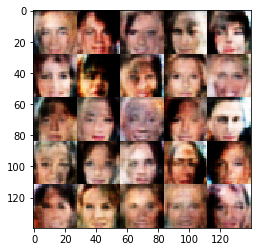

Epoch 2/10... Discriminator Loss: 0.5982... Generator Loss: 2.7331
Epoch 2/10... Discriminator Loss: 2.3325... Generator Loss: 0.1948
Epoch 2/10... Discriminator Loss: 0.9213... Generator Loss: 1.2629
Epoch 2/10... Discriminator Loss: 0.9007... Generator Loss: 1.1101
Epoch 2/10... Discriminator Loss: 0.5957... Generator Loss: 3.3269
Epoch 2/10... Discriminator Loss: 0.8061... Generator Loss: 1.2817
Epoch 2/10... Discriminator Loss: 0.4893... Generator Loss: 4.8681
Epoch 2/10... Discriminator Loss: 0.5534... Generator Loss: 3.4611
Epoch 2/10... Discriminator Loss: 0.6255... Generator Loss: 2.3539
Epoch 2/10... Discriminator Loss: 0.6210... Generator Loss: 2.0185


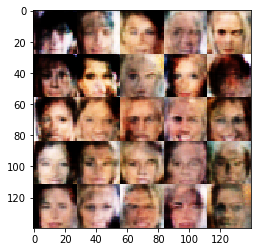

Epoch 2/10... Discriminator Loss: 0.7505... Generator Loss: 1.4745
Epoch 2/10... Discriminator Loss: 0.8513... Generator Loss: 4.6289
Epoch 2/10... Discriminator Loss: 1.7291... Generator Loss: 2.0689
Epoch 2/10... Discriminator Loss: 1.5050... Generator Loss: 0.4547
Epoch 2/10... Discriminator Loss: 1.4812... Generator Loss: 0.5456
Epoch 2/10... Discriminator Loss: 1.0390... Generator Loss: 1.9773
Epoch 2/10... Discriminator Loss: 0.6045... Generator Loss: 2.3990
Epoch 2/10... Discriminator Loss: 0.6133... Generator Loss: 3.5621
Epoch 2/10... Discriminator Loss: 1.0310... Generator Loss: 1.3429
Epoch 2/10... Discriminator Loss: 0.5595... Generator Loss: 2.9520


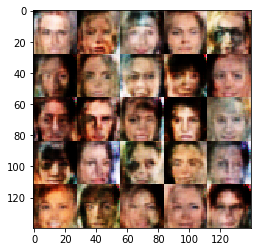

Epoch 2/10... Discriminator Loss: 1.0522... Generator Loss: 1.1986
Epoch 2/10... Discriminator Loss: 0.6539... Generator Loss: 1.6838
Epoch 2/10... Discriminator Loss: 0.9034... Generator Loss: 1.1252
Epoch 2/10... Discriminator Loss: 0.5503... Generator Loss: 2.2643
Epoch 2/10... Discriminator Loss: 0.7802... Generator Loss: 1.4927
Epoch 2/10... Discriminator Loss: 1.6760... Generator Loss: 0.5973
Epoch 2/10... Discriminator Loss: 0.5841... Generator Loss: 2.5878
Epoch 2/10... Discriminator Loss: 0.7802... Generator Loss: 1.4477
Epoch 2/10... Discriminator Loss: 0.5959... Generator Loss: 2.9336
Epoch 2/10... Discriminator Loss: 0.4774... Generator Loss: 3.3956


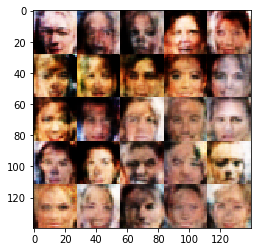

Epoch 2/10... Discriminator Loss: 3.3081... Generator Loss: 3.9452
Epoch 2/10... Discriminator Loss: 0.7145... Generator Loss: 3.8643
Epoch 2/10... Discriminator Loss: 0.7443... Generator Loss: 2.1838
Epoch 2/10... Discriminator Loss: 0.6325... Generator Loss: 1.9334
Epoch 2/10... Discriminator Loss: 0.5958... Generator Loss: 2.5096
Epoch 2/10... Discriminator Loss: 0.9324... Generator Loss: 0.9877
Epoch 2/10... Discriminator Loss: 1.1483... Generator Loss: 1.3707
Epoch 2/10... Discriminator Loss: 0.7156... Generator Loss: 3.3799
Epoch 2/10... Discriminator Loss: 0.6199... Generator Loss: 2.6604
Epoch 2/10... Discriminator Loss: 0.6588... Generator Loss: 3.7708


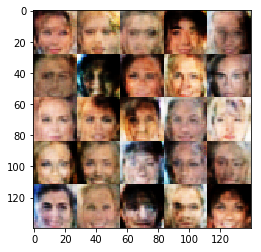

Epoch 2/10... Discriminator Loss: 1.3939... Generator Loss: 0.7714
Epoch 2/10... Discriminator Loss: 0.9646... Generator Loss: 1.2093
Epoch 2/10... Discriminator Loss: 1.4213... Generator Loss: 2.5054
Epoch 2/10... Discriminator Loss: 0.9406... Generator Loss: 1.0717
Epoch 2/10... Discriminator Loss: 0.9026... Generator Loss: 1.1294
Epoch 2/10... Discriminator Loss: 0.8485... Generator Loss: 1.5928
Epoch 2/10... Discriminator Loss: 0.7976... Generator Loss: 1.6706
Epoch 2/10... Discriminator Loss: 0.7249... Generator Loss: 3.5537
Epoch 2/10... Discriminator Loss: 1.5716... Generator Loss: 0.4852
Epoch 2/10... Discriminator Loss: 0.7373... Generator Loss: 3.7398


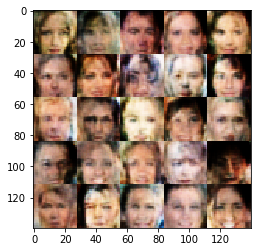

Epoch 2/10... Discriminator Loss: 1.2125... Generator Loss: 0.8217
Epoch 2/10... Discriminator Loss: 0.6468... Generator Loss: 2.3925
Epoch 2/10... Discriminator Loss: 0.5349... Generator Loss: 4.7322
Epoch 2/10... Discriminator Loss: 0.9564... Generator Loss: 1.3221
Epoch 2/10... Discriminator Loss: 0.7110... Generator Loss: 1.9371
Epoch 2/10... Discriminator Loss: 1.0472... Generator Loss: 0.9029
Epoch 2/10... Discriminator Loss: 0.6962... Generator Loss: 1.7573
Epoch 2/10... Discriminator Loss: 0.7783... Generator Loss: 1.6242
Epoch 2/10... Discriminator Loss: 0.5875... Generator Loss: 3.0068
Epoch 2/10... Discriminator Loss: 0.6348... Generator Loss: 2.2159


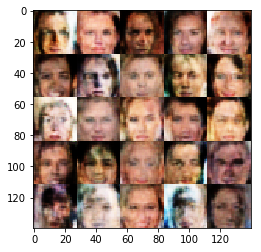

Epoch 2/10... Discriminator Loss: 2.1344... Generator Loss: 0.2565
Epoch 2/10... Discriminator Loss: 0.6718... Generator Loss: 2.8199
Epoch 2/10... Discriminator Loss: 0.6565... Generator Loss: 2.6416
Epoch 2/10... Discriminator Loss: 0.8533... Generator Loss: 3.4689
Epoch 2/10... Discriminator Loss: 0.5954... Generator Loss: 2.3386
Epoch 2/10... Discriminator Loss: 1.7794... Generator Loss: 0.3414
Epoch 2/10... Discriminator Loss: 0.6681... Generator Loss: 2.2521
Epoch 2/10... Discriminator Loss: 1.0279... Generator Loss: 2.7362
Epoch 2/10... Discriminator Loss: 0.6381... Generator Loss: 2.6035
Epoch 2/10... Discriminator Loss: 0.9528... Generator Loss: 2.5189


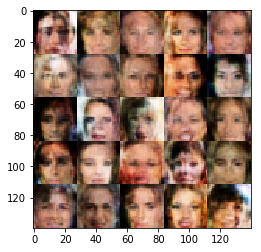

Epoch 2/10... Discriminator Loss: 0.7849... Generator Loss: 1.9889
Epoch 2/10... Discriminator Loss: 0.7014... Generator Loss: 1.6913
Epoch 2/10... Discriminator Loss: 1.5465... Generator Loss: 0.8573
Epoch 2/10... Discriminator Loss: 1.0289... Generator Loss: 3.1735
Epoch 2/10... Discriminator Loss: 0.9631... Generator Loss: 1.2110
Epoch 2/10... Discriminator Loss: 0.8783... Generator Loss: 1.4125
Epoch 2/10... Discriminator Loss: 0.5577... Generator Loss: 2.6315
Epoch 2/10... Discriminator Loss: 1.5666... Generator Loss: 0.5549
Epoch 3/10... Discriminator Loss: 0.9360... Generator Loss: 1.1209
Epoch 3/10... Discriminator Loss: 0.7385... Generator Loss: 2.2906


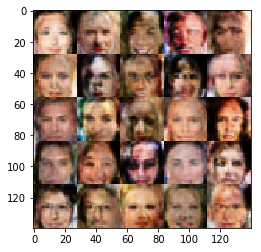

Epoch 3/10... Discriminator Loss: 0.7764... Generator Loss: 1.6630
Epoch 3/10... Discriminator Loss: 0.7469... Generator Loss: 3.4863
Epoch 3/10... Discriminator Loss: 0.7532... Generator Loss: 1.4946
Epoch 3/10... Discriminator Loss: 1.7530... Generator Loss: 2.9005
Epoch 3/10... Discriminator Loss: 0.5656... Generator Loss: 3.6268
Epoch 3/10... Discriminator Loss: 0.9650... Generator Loss: 1.1920
Epoch 3/10... Discriminator Loss: 0.7558... Generator Loss: 1.4981
Epoch 3/10... Discriminator Loss: 1.3992... Generator Loss: 2.3954
Epoch 3/10... Discriminator Loss: 0.9736... Generator Loss: 3.7230
Epoch 3/10... Discriminator Loss: 0.7437... Generator Loss: 1.6339


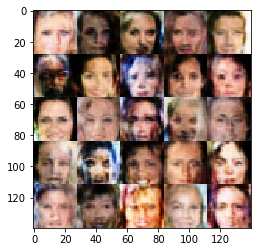

Epoch 3/10... Discriminator Loss: 0.6927... Generator Loss: 2.1175
Epoch 3/10... Discriminator Loss: 1.3421... Generator Loss: 2.0077
Epoch 3/10... Discriminator Loss: 0.9147... Generator Loss: 1.7061
Epoch 3/10... Discriminator Loss: 0.9552... Generator Loss: 2.3071
Epoch 3/10... Discriminator Loss: 0.9558... Generator Loss: 2.8267
Epoch 3/10... Discriminator Loss: 1.2040... Generator Loss: 1.5123
Epoch 3/10... Discriminator Loss: 0.7135... Generator Loss: 2.3194
Epoch 3/10... Discriminator Loss: 1.0081... Generator Loss: 0.9623
Epoch 3/10... Discriminator Loss: 1.1461... Generator Loss: 0.7296
Epoch 3/10... Discriminator Loss: 0.9643... Generator Loss: 1.0341


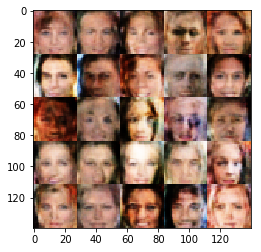

Epoch 3/10... Discriminator Loss: 0.9827... Generator Loss: 1.0843
Epoch 3/10... Discriminator Loss: 0.7031... Generator Loss: 2.5075
Epoch 3/10... Discriminator Loss: 0.7385... Generator Loss: 2.0776
Epoch 3/10... Discriminator Loss: 0.8418... Generator Loss: 1.2946
Epoch 3/10... Discriminator Loss: 0.6548... Generator Loss: 1.9414
Epoch 3/10... Discriminator Loss: 0.5967... Generator Loss: 2.7639
Epoch 3/10... Discriminator Loss: 1.1588... Generator Loss: 0.7805
Epoch 3/10... Discriminator Loss: 1.6417... Generator Loss: 3.9762
Epoch 3/10... Discriminator Loss: 1.1540... Generator Loss: 0.8761
Epoch 3/10... Discriminator Loss: 0.9528... Generator Loss: 1.0882


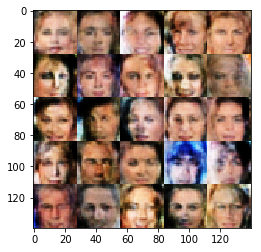

Epoch 3/10... Discriminator Loss: 0.8006... Generator Loss: 1.5296
Epoch 3/10... Discriminator Loss: 0.8886... Generator Loss: 2.9938
Epoch 3/10... Discriminator Loss: 0.7682... Generator Loss: 1.7747
Epoch 3/10... Discriminator Loss: 0.6972... Generator Loss: 2.4761
Epoch 3/10... Discriminator Loss: 1.3557... Generator Loss: 0.5519
Epoch 3/10... Discriminator Loss: 0.7930... Generator Loss: 1.7557
Epoch 3/10... Discriminator Loss: 0.7354... Generator Loss: 1.9190
Epoch 3/10... Discriminator Loss: 0.7259... Generator Loss: 1.8302
Epoch 3/10... Discriminator Loss: 0.8085... Generator Loss: 3.1074
Epoch 3/10... Discriminator Loss: 0.7663... Generator Loss: 1.8030


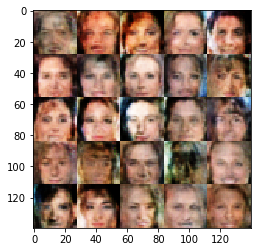

Epoch 3/10... Discriminator Loss: 1.5458... Generator Loss: 2.3667
Epoch 3/10... Discriminator Loss: 0.9814... Generator Loss: 1.1936
Epoch 3/10... Discriminator Loss: 0.6001... Generator Loss: 2.6853
Epoch 3/10... Discriminator Loss: 0.6939... Generator Loss: 2.2815
Epoch 3/10... Discriminator Loss: 0.8179... Generator Loss: 1.3686
Epoch 3/10... Discriminator Loss: 1.7729... Generator Loss: 0.7382
Epoch 3/10... Discriminator Loss: 0.7949... Generator Loss: 1.7739
Epoch 3/10... Discriminator Loss: 0.8839... Generator Loss: 1.5822
Epoch 3/10... Discriminator Loss: 0.7962... Generator Loss: 2.0718
Epoch 3/10... Discriminator Loss: 1.0047... Generator Loss: 1.6633


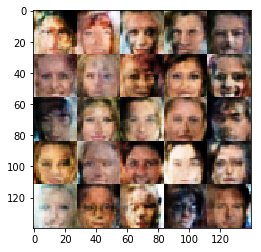

Epoch 3/10... Discriminator Loss: 1.7923... Generator Loss: 0.3574
Epoch 3/10... Discriminator Loss: 1.2867... Generator Loss: 3.0185
Epoch 3/10... Discriminator Loss: 0.7685... Generator Loss: 1.8957
Epoch 3/10... Discriminator Loss: 1.1231... Generator Loss: 2.7541
Epoch 3/10... Discriminator Loss: 0.8644... Generator Loss: 1.6786
Epoch 3/10... Discriminator Loss: 0.6593... Generator Loss: 2.0123
Epoch 3/10... Discriminator Loss: 0.8811... Generator Loss: 1.9567
Epoch 3/10... Discriminator Loss: 0.7386... Generator Loss: 1.6038
Epoch 3/10... Discriminator Loss: 1.2095... Generator Loss: 0.7487
Epoch 3/10... Discriminator Loss: 1.8523... Generator Loss: 0.5462


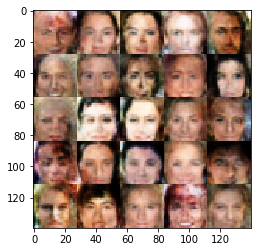

Epoch 3/10... Discriminator Loss: 1.8384... Generator Loss: 2.0439
Epoch 3/10... Discriminator Loss: 1.0795... Generator Loss: 1.1749
Epoch 3/10... Discriminator Loss: 1.0577... Generator Loss: 1.0723
Epoch 3/10... Discriminator Loss: 0.7813... Generator Loss: 2.3190
Epoch 3/10... Discriminator Loss: 0.8878... Generator Loss: 1.2066
Epoch 3/10... Discriminator Loss: 0.8194... Generator Loss: 1.6278
Epoch 3/10... Discriminator Loss: 1.1478... Generator Loss: 0.8957
Epoch 3/10... Discriminator Loss: 1.1308... Generator Loss: 0.8336
Epoch 3/10... Discriminator Loss: 0.7773... Generator Loss: 1.6679
Epoch 3/10... Discriminator Loss: 0.7843... Generator Loss: 2.0408


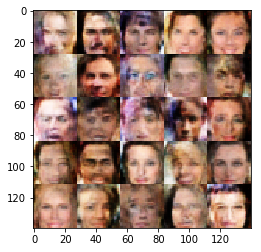

Epoch 3/10... Discriminator Loss: 0.7610... Generator Loss: 1.8766
Epoch 3/10... Discriminator Loss: 1.2748... Generator Loss: 2.1344
Epoch 3/10... Discriminator Loss: 0.9779... Generator Loss: 1.5171
Epoch 3/10... Discriminator Loss: 1.0076... Generator Loss: 1.4812
Epoch 3/10... Discriminator Loss: 0.7780... Generator Loss: 1.4614
Epoch 3/10... Discriminator Loss: 0.8875... Generator Loss: 2.4311
Epoch 3/10... Discriminator Loss: 1.1840... Generator Loss: 2.9739
Epoch 4/10... Discriminator Loss: 0.9303... Generator Loss: 1.2803
Epoch 4/10... Discriminator Loss: 0.9220... Generator Loss: 1.1649
Epoch 4/10... Discriminator Loss: 2.5848... Generator Loss: 3.5968


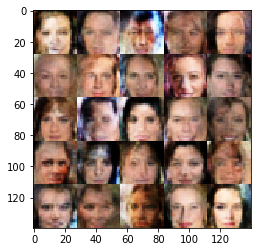

Epoch 4/10... Discriminator Loss: 1.1305... Generator Loss: 1.0325
Epoch 4/10... Discriminator Loss: 0.7378... Generator Loss: 2.1690
Epoch 4/10... Discriminator Loss: 0.9954... Generator Loss: 1.4876
Epoch 4/10... Discriminator Loss: 0.6926... Generator Loss: 2.0261
Epoch 4/10... Discriminator Loss: 0.7731... Generator Loss: 1.7599
Epoch 4/10... Discriminator Loss: 0.9475... Generator Loss: 1.2209
Epoch 4/10... Discriminator Loss: 1.1197... Generator Loss: 2.4706
Epoch 4/10... Discriminator Loss: 0.8930... Generator Loss: 1.2488
Epoch 4/10... Discriminator Loss: 1.0850... Generator Loss: 0.8665
Epoch 4/10... Discriminator Loss: 0.7207... Generator Loss: 1.9861


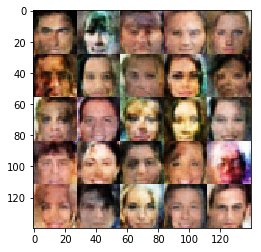

Epoch 4/10... Discriminator Loss: 1.3803... Generator Loss: 0.6505
Epoch 4/10... Discriminator Loss: 0.7520... Generator Loss: 2.1518
Epoch 4/10... Discriminator Loss: 1.0966... Generator Loss: 0.9972
Epoch 4/10... Discriminator Loss: 0.9335... Generator Loss: 1.2877
Epoch 4/10... Discriminator Loss: 0.9677... Generator Loss: 1.0096
Epoch 4/10... Discriminator Loss: 0.8757... Generator Loss: 1.4288
Epoch 4/10... Discriminator Loss: 0.9328... Generator Loss: 2.2049
Epoch 4/10... Discriminator Loss: 1.0733... Generator Loss: 1.2381
Epoch 4/10... Discriminator Loss: 0.9035... Generator Loss: 1.2591
Epoch 4/10... Discriminator Loss: 0.7574... Generator Loss: 1.6920


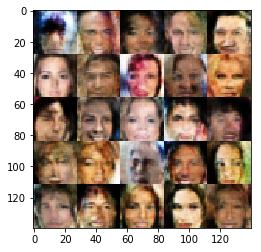

Epoch 4/10... Discriminator Loss: 0.7643... Generator Loss: 1.8016
Epoch 4/10... Discriminator Loss: 0.9585... Generator Loss: 1.0535
Epoch 4/10... Discriminator Loss: 2.0305... Generator Loss: 0.2698
Epoch 4/10... Discriminator Loss: 0.9978... Generator Loss: 1.0364
Epoch 4/10... Discriminator Loss: 0.5793... Generator Loss: 3.1485
Epoch 4/10... Discriminator Loss: 0.9743... Generator Loss: 2.3865
Epoch 4/10... Discriminator Loss: 0.8659... Generator Loss: 1.4895
Epoch 4/10... Discriminator Loss: 1.0434... Generator Loss: 2.4889
Epoch 4/10... Discriminator Loss: 0.6459... Generator Loss: 4.3640
Epoch 4/10... Discriminator Loss: 0.7958... Generator Loss: 1.6309


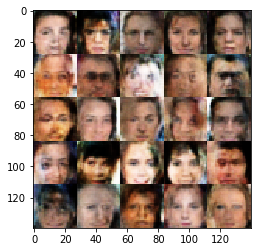

Epoch 4/10... Discriminator Loss: 1.4390... Generator Loss: 2.3762
Epoch 4/10... Discriminator Loss: 0.9602... Generator Loss: 2.0070
Epoch 4/10... Discriminator Loss: 0.9140... Generator Loss: 1.0745
Epoch 4/10... Discriminator Loss: 0.8817... Generator Loss: 2.2436
Epoch 4/10... Discriminator Loss: 0.8762... Generator Loss: 1.7963
Epoch 4/10... Discriminator Loss: 1.0045... Generator Loss: 1.4424
Epoch 4/10... Discriminator Loss: 0.9635... Generator Loss: 2.4751
Epoch 4/10... Discriminator Loss: 0.9399... Generator Loss: 1.0024
Epoch 4/10... Discriminator Loss: 0.7682... Generator Loss: 2.2026
Epoch 4/10... Discriminator Loss: 2.1496... Generator Loss: 0.3355


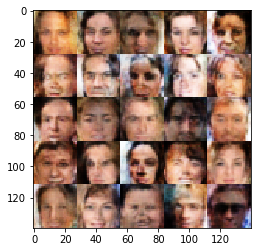

Epoch 4/10... Discriminator Loss: 0.9200... Generator Loss: 1.5874
Epoch 4/10... Discriminator Loss: 0.6683... Generator Loss: 2.8742
Epoch 4/10... Discriminator Loss: 0.7716... Generator Loss: 1.9740
Epoch 4/10... Discriminator Loss: 0.7590... Generator Loss: 2.5446
Epoch 4/10... Discriminator Loss: 1.9311... Generator Loss: 0.3166
Epoch 4/10... Discriminator Loss: 1.1243... Generator Loss: 0.8510
Epoch 4/10... Discriminator Loss: 1.1033... Generator Loss: 2.2075
Epoch 4/10... Discriminator Loss: 0.7549... Generator Loss: 2.2797
Epoch 4/10... Discriminator Loss: 0.8829... Generator Loss: 1.2777
Epoch 4/10... Discriminator Loss: 1.1500... Generator Loss: 0.7445


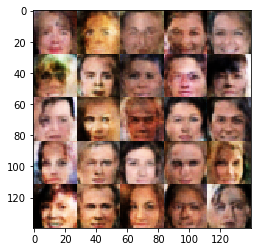

Epoch 4/10... Discriminator Loss: 0.9627... Generator Loss: 1.1597
Epoch 4/10... Discriminator Loss: 1.1641... Generator Loss: 2.1836
Epoch 4/10... Discriminator Loss: 1.0177... Generator Loss: 1.0370
Epoch 4/10... Discriminator Loss: 0.8790... Generator Loss: 1.3487
Epoch 4/10... Discriminator Loss: 1.3679... Generator Loss: 2.4926
Epoch 4/10... Discriminator Loss: 0.9058... Generator Loss: 1.3173
Epoch 4/10... Discriminator Loss: 0.8042... Generator Loss: 1.4982
Epoch 4/10... Discriminator Loss: 1.0502... Generator Loss: 0.8842
Epoch 4/10... Discriminator Loss: 0.7663... Generator Loss: 2.0296
Epoch 4/10... Discriminator Loss: 0.8737... Generator Loss: 6.7104


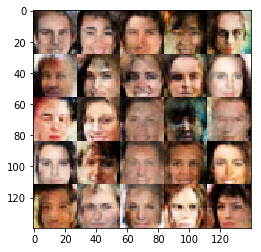

Epoch 4/10... Discriminator Loss: 0.9983... Generator Loss: 1.1625
Epoch 4/10... Discriminator Loss: 1.6174... Generator Loss: 2.7937
Epoch 4/10... Discriminator Loss: 0.9875... Generator Loss: 1.5268
Epoch 4/10... Discriminator Loss: 0.7236... Generator Loss: 2.1535
Epoch 4/10... Discriminator Loss: 0.6913... Generator Loss: 2.4172
Epoch 4/10... Discriminator Loss: 1.2068... Generator Loss: 1.6936
Epoch 4/10... Discriminator Loss: 1.3677... Generator Loss: 1.3830
Epoch 4/10... Discriminator Loss: 0.9294... Generator Loss: 1.5854
Epoch 4/10... Discriminator Loss: 0.6700... Generator Loss: 2.8809
Epoch 4/10... Discriminator Loss: 0.9654... Generator Loss: 2.2898


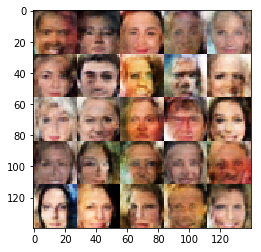

Epoch 4/10... Discriminator Loss: 1.6835... Generator Loss: 0.4002
Epoch 4/10... Discriminator Loss: 1.1465... Generator Loss: 1.0279
Epoch 4/10... Discriminator Loss: 0.8381... Generator Loss: 1.4453
Epoch 4/10... Discriminator Loss: 0.8723... Generator Loss: 1.5973
Epoch 4/10... Discriminator Loss: 0.8132... Generator Loss: 1.9938
Epoch 4/10... Discriminator Loss: 0.8854... Generator Loss: 2.3865
Epoch 5/10... Discriminator Loss: 0.9271... Generator Loss: 1.0753
Epoch 5/10... Discriminator Loss: 2.2956... Generator Loss: 1.4221
Epoch 5/10... Discriminator Loss: 1.9836... Generator Loss: 0.4596
Epoch 5/10... Discriminator Loss: 1.2822... Generator Loss: 0.9174


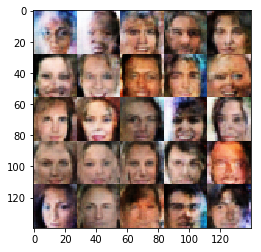

Epoch 5/10... Discriminator Loss: 1.1802... Generator Loss: 1.5565
Epoch 5/10... Discriminator Loss: 0.8663... Generator Loss: 1.5803
Epoch 5/10... Discriminator Loss: 0.9714... Generator Loss: 1.7526
Epoch 5/10... Discriminator Loss: 0.9814... Generator Loss: 1.0028
Epoch 5/10... Discriminator Loss: 0.8701... Generator Loss: 1.3540
Epoch 5/10... Discriminator Loss: 0.7561... Generator Loss: 1.9341
Epoch 5/10... Discriminator Loss: 1.0964... Generator Loss: 1.9548
Epoch 5/10... Discriminator Loss: 0.8770... Generator Loss: 1.4972
Epoch 5/10... Discriminator Loss: 1.5575... Generator Loss: 1.9392
Epoch 5/10... Discriminator Loss: 1.2897... Generator Loss: 1.3891


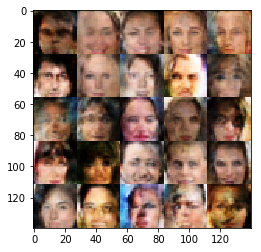

Epoch 5/10... Discriminator Loss: 1.0783... Generator Loss: 0.9031
Epoch 5/10... Discriminator Loss: 0.8980... Generator Loss: 1.9558
Epoch 5/10... Discriminator Loss: 1.0735... Generator Loss: 1.9905
Epoch 5/10... Discriminator Loss: 0.8188... Generator Loss: 1.7485
Epoch 5/10... Discriminator Loss: 0.8772... Generator Loss: 1.2145
Epoch 5/10... Discriminator Loss: 0.7582... Generator Loss: 1.3522
Epoch 5/10... Discriminator Loss: 1.1465... Generator Loss: 0.7412
Epoch 5/10... Discriminator Loss: 1.4206... Generator Loss: 1.8499
Epoch 5/10... Discriminator Loss: 1.0239... Generator Loss: 1.3969
Epoch 5/10... Discriminator Loss: 0.9728... Generator Loss: 1.2826


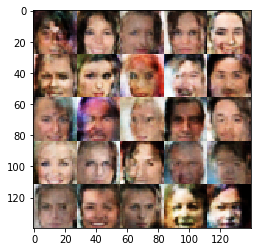

Epoch 5/10... Discriminator Loss: 0.9544... Generator Loss: 1.3327
Epoch 5/10... Discriminator Loss: 0.9205... Generator Loss: 2.1226
Epoch 5/10... Discriminator Loss: 0.7508... Generator Loss: 1.6278
Epoch 5/10... Discriminator Loss: 0.9346... Generator Loss: 2.4718
Epoch 5/10... Discriminator Loss: 1.2677... Generator Loss: 1.8721
Epoch 5/10... Discriminator Loss: 1.4216... Generator Loss: 0.5156
Epoch 5/10... Discriminator Loss: 2.8246... Generator Loss: 1.5788
Epoch 5/10... Discriminator Loss: 1.4136... Generator Loss: 0.6480
Epoch 5/10... Discriminator Loss: 1.4375... Generator Loss: 0.7596
Epoch 5/10... Discriminator Loss: 1.3877... Generator Loss: 1.0020


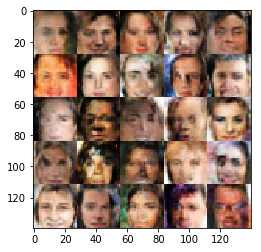

Epoch 5/10... Discriminator Loss: 1.4517... Generator Loss: 1.0162
Epoch 5/10... Discriminator Loss: 1.3353... Generator Loss: 1.3217
Epoch 5/10... Discriminator Loss: 1.6170... Generator Loss: 2.7740
Epoch 5/10... Discriminator Loss: 1.1752... Generator Loss: 0.9420
Epoch 5/10... Discriminator Loss: 1.0682... Generator Loss: 0.9196
Epoch 5/10... Discriminator Loss: 1.2608... Generator Loss: 1.8778
Epoch 5/10... Discriminator Loss: 1.0457... Generator Loss: 0.9405
Epoch 5/10... Discriminator Loss: 0.8051... Generator Loss: 2.0122
Epoch 5/10... Discriminator Loss: 1.1091... Generator Loss: 0.9039
Epoch 5/10... Discriminator Loss: 0.9492... Generator Loss: 1.5723


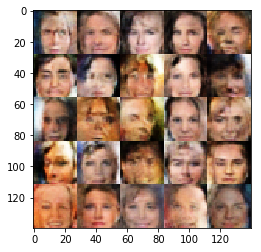

Epoch 5/10... Discriminator Loss: 1.0287... Generator Loss: 0.8385
Epoch 5/10... Discriminator Loss: 1.0875... Generator Loss: 0.8335
Epoch 5/10... Discriminator Loss: 0.7593... Generator Loss: 2.5565
Epoch 5/10... Discriminator Loss: 1.1448... Generator Loss: 0.7774
Epoch 5/10... Discriminator Loss: 0.7804... Generator Loss: 1.8165
Epoch 5/10... Discriminator Loss: 0.9216... Generator Loss: 1.0931
Epoch 5/10... Discriminator Loss: 0.7848... Generator Loss: 1.5628
Epoch 5/10... Discriminator Loss: 2.1892... Generator Loss: 0.2468
Epoch 5/10... Discriminator Loss: 1.4292... Generator Loss: 1.3769
Epoch 5/10... Discriminator Loss: 1.4296... Generator Loss: 0.9974


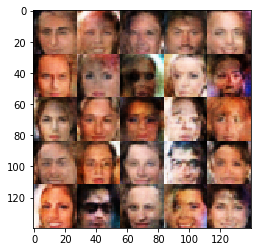

Epoch 5/10... Discriminator Loss: 1.1712... Generator Loss: 0.7864
Epoch 5/10... Discriminator Loss: 0.9315... Generator Loss: 1.7348
Epoch 5/10... Discriminator Loss: 1.0655... Generator Loss: 0.9051
Epoch 5/10... Discriminator Loss: 1.1886... Generator Loss: 0.7067
Epoch 5/10... Discriminator Loss: 0.6765... Generator Loss: 2.1027
Epoch 5/10... Discriminator Loss: 0.8376... Generator Loss: 1.3894
Epoch 5/10... Discriminator Loss: 0.7625... Generator Loss: 1.6007
Epoch 5/10... Discriminator Loss: 1.2004... Generator Loss: 1.2565
Epoch 5/10... Discriminator Loss: 0.6979... Generator Loss: 3.4924
Epoch 5/10... Discriminator Loss: 0.8906... Generator Loss: 1.1425


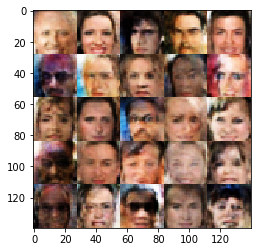

Epoch 5/10... Discriminator Loss: 1.6338... Generator Loss: 0.3995
Epoch 5/10... Discriminator Loss: 1.2757... Generator Loss: 0.6367
Epoch 5/10... Discriminator Loss: 0.8975... Generator Loss: 1.7988
Epoch 5/10... Discriminator Loss: 0.9391... Generator Loss: 1.2194
Epoch 5/10... Discriminator Loss: 0.8617... Generator Loss: 1.3799
Epoch 5/10... Discriminator Loss: 1.5846... Generator Loss: 0.4230
Epoch 5/10... Discriminator Loss: 0.7934... Generator Loss: 1.8340
Epoch 5/10... Discriminator Loss: 0.8840... Generator Loss: 1.5037
Epoch 5/10... Discriminator Loss: 1.2110... Generator Loss: 2.0462
Epoch 5/10... Discriminator Loss: 1.0335... Generator Loss: 1.4986


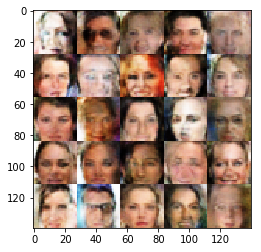

Epoch 5/10... Discriminator Loss: 0.8770... Generator Loss: 1.4248
Epoch 5/10... Discriminator Loss: 1.0926... Generator Loss: 1.9025
Epoch 5/10... Discriminator Loss: 0.8314... Generator Loss: 1.7057
Epoch 5/10... Discriminator Loss: 0.8738... Generator Loss: 1.4203
Epoch 5/10... Discriminator Loss: 0.8883... Generator Loss: 2.5793
Epoch 6/10... Discriminator Loss: 0.9157... Generator Loss: 1.1417
Epoch 6/10... Discriminator Loss: 1.1405... Generator Loss: 0.7724
Epoch 6/10... Discriminator Loss: 1.9686... Generator Loss: 0.2812
Epoch 6/10... Discriminator Loss: 1.1080... Generator Loss: 1.9767
Epoch 6/10... Discriminator Loss: 1.2416... Generator Loss: 1.9635


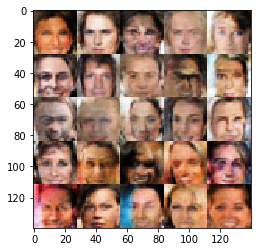

Epoch 6/10... Discriminator Loss: 0.7943... Generator Loss: 1.7248
Epoch 6/10... Discriminator Loss: 0.9677... Generator Loss: 1.0584
Epoch 6/10... Discriminator Loss: 1.2236... Generator Loss: 0.6786
Epoch 6/10... Discriminator Loss: 1.3757... Generator Loss: 2.2360
Epoch 6/10... Discriminator Loss: 0.9208... Generator Loss: 1.4893
Epoch 6/10... Discriminator Loss: 0.9899... Generator Loss: 1.0637
Epoch 6/10... Discriminator Loss: 0.8446... Generator Loss: 2.0056
Epoch 6/10... Discriminator Loss: 0.9526... Generator Loss: 1.0545
Epoch 6/10... Discriminator Loss: 0.8662... Generator Loss: 2.2252
Epoch 6/10... Discriminator Loss: 0.8706... Generator Loss: 1.3856


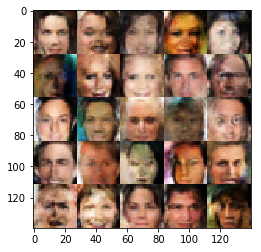

Epoch 6/10... Discriminator Loss: 1.9252... Generator Loss: 0.2900
Epoch 6/10... Discriminator Loss: 1.2057... Generator Loss: 0.8086
Epoch 6/10... Discriminator Loss: 0.8910... Generator Loss: 1.5020
Epoch 6/10... Discriminator Loss: 0.9173... Generator Loss: 1.1668
Epoch 6/10... Discriminator Loss: 1.0347... Generator Loss: 0.9661
Epoch 6/10... Discriminator Loss: 0.8536... Generator Loss: 2.1656
Epoch 6/10... Discriminator Loss: 0.9778... Generator Loss: 1.0476
Epoch 6/10... Discriminator Loss: 1.0351... Generator Loss: 0.9265
Epoch 6/10... Discriminator Loss: 0.9224... Generator Loss: 1.1498
Epoch 6/10... Discriminator Loss: 1.0241... Generator Loss: 1.2703


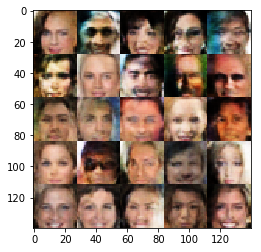

Epoch 6/10... Discriminator Loss: 0.8173... Generator Loss: 1.7104
Epoch 6/10... Discriminator Loss: 3.5159... Generator Loss: 5.0939
Epoch 6/10... Discriminator Loss: 1.3542... Generator Loss: 0.6773
Epoch 6/10... Discriminator Loss: 1.4609... Generator Loss: 0.5793
Epoch 6/10... Discriminator Loss: 1.2643... Generator Loss: 0.8072
Epoch 6/10... Discriminator Loss: 1.1177... Generator Loss: 0.9292
Epoch 6/10... Discriminator Loss: 0.9690... Generator Loss: 1.0602
Epoch 6/10... Discriminator Loss: 1.2171... Generator Loss: 0.6707
Epoch 6/10... Discriminator Loss: 1.0817... Generator Loss: 0.9310
Epoch 6/10... Discriminator Loss: 1.1322... Generator Loss: 0.8884


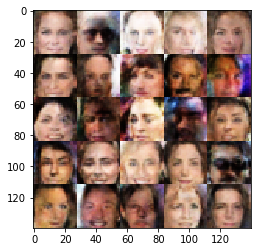

Epoch 6/10... Discriminator Loss: 1.0512... Generator Loss: 0.9519
Epoch 6/10... Discriminator Loss: 0.9568... Generator Loss: 1.2209
Epoch 6/10... Discriminator Loss: 0.9002... Generator Loss: 1.3930
Epoch 6/10... Discriminator Loss: 0.8437... Generator Loss: 1.7913
Epoch 6/10... Discriminator Loss: 0.9260... Generator Loss: 1.0876
Epoch 6/10... Discriminator Loss: 0.9923... Generator Loss: 1.0009
Epoch 6/10... Discriminator Loss: 0.8828... Generator Loss: 1.6686
Epoch 6/10... Discriminator Loss: 1.3166... Generator Loss: 0.8442
Epoch 6/10... Discriminator Loss: 1.2474... Generator Loss: 0.7874
Epoch 6/10... Discriminator Loss: 0.9464... Generator Loss: 1.2336


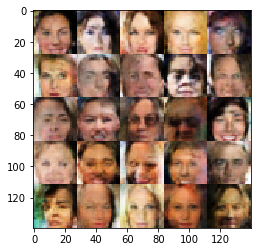

Epoch 6/10... Discriminator Loss: 0.9070... Generator Loss: 1.1148
Epoch 6/10... Discriminator Loss: 0.9909... Generator Loss: 0.9880
Epoch 6/10... Discriminator Loss: 0.8356... Generator Loss: 1.7229
Epoch 6/10... Discriminator Loss: 0.9347... Generator Loss: 1.0590
Epoch 6/10... Discriminator Loss: 1.1523... Generator Loss: 0.7500
Epoch 6/10... Discriminator Loss: 1.2254... Generator Loss: 0.6987
Epoch 6/10... Discriminator Loss: 1.0855... Generator Loss: 2.2364
Epoch 6/10... Discriminator Loss: 1.1422... Generator Loss: 0.7831
Epoch 6/10... Discriminator Loss: 0.9293... Generator Loss: 1.0979
Epoch 6/10... Discriminator Loss: 0.8221... Generator Loss: 2.0171


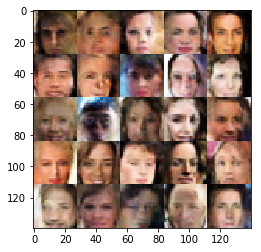

Epoch 6/10... Discriminator Loss: 0.8507... Generator Loss: 1.2443
Epoch 6/10... Discriminator Loss: 0.8273... Generator Loss: 1.9586
Epoch 6/10... Discriminator Loss: 1.0158... Generator Loss: 0.8746
Epoch 6/10... Discriminator Loss: 1.4412... Generator Loss: 0.7508
Epoch 6/10... Discriminator Loss: 1.4607... Generator Loss: 0.6709
Epoch 6/10... Discriminator Loss: 1.3447... Generator Loss: 0.9580
Epoch 6/10... Discriminator Loss: 1.3623... Generator Loss: 1.0859
Epoch 6/10... Discriminator Loss: 1.2455... Generator Loss: 0.7496
Epoch 6/10... Discriminator Loss: 0.9015... Generator Loss: 2.0505
Epoch 6/10... Discriminator Loss: 1.2489... Generator Loss: 0.9980


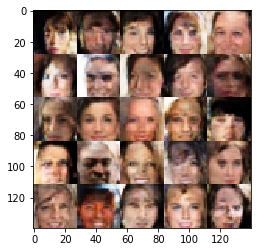

Epoch 6/10... Discriminator Loss: 1.1250... Generator Loss: 1.5961
Epoch 6/10... Discriminator Loss: 0.9887... Generator Loss: 1.5753
Epoch 6/10... Discriminator Loss: 0.8793... Generator Loss: 1.8795
Epoch 6/10... Discriminator Loss: 0.9489... Generator Loss: 1.1207
Epoch 6/10... Discriminator Loss: 1.4037... Generator Loss: 2.4905
Epoch 6/10... Discriminator Loss: 1.0535... Generator Loss: 1.3301
Epoch 6/10... Discriminator Loss: 1.3510... Generator Loss: 2.1167
Epoch 6/10... Discriminator Loss: 0.9609... Generator Loss: 1.2135
Epoch 6/10... Discriminator Loss: 0.8631... Generator Loss: 1.6995
Epoch 6/10... Discriminator Loss: 0.9793... Generator Loss: 1.4833


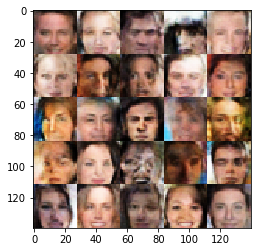

Epoch 6/10... Discriminator Loss: 0.8428... Generator Loss: 1.4446
Epoch 6/10... Discriminator Loss: 1.8773... Generator Loss: 2.6843
Epoch 6/10... Discriminator Loss: 1.1049... Generator Loss: 0.7907
Epoch 6/10... Discriminator Loss: 0.9314... Generator Loss: 1.5424
Epoch 7/10... Discriminator Loss: 0.7988... Generator Loss: 2.3908
Epoch 7/10... Discriminator Loss: 1.2504... Generator Loss: 2.3594
Epoch 7/10... Discriminator Loss: 0.9626... Generator Loss: 1.0653
Epoch 7/10... Discriminator Loss: 1.9303... Generator Loss: 0.3886
Epoch 7/10... Discriminator Loss: 1.2357... Generator Loss: 1.0172
Epoch 7/10... Discriminator Loss: 1.4487... Generator Loss: 2.0628


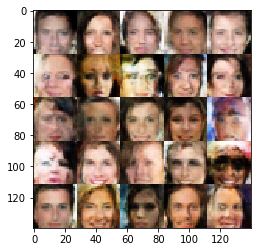

Epoch 7/10... Discriminator Loss: 0.8729... Generator Loss: 1.4933
Epoch 7/10... Discriminator Loss: 0.9231... Generator Loss: 1.1326
Epoch 7/10... Discriminator Loss: 0.8543... Generator Loss: 1.2036
Epoch 7/10... Discriminator Loss: 1.0691... Generator Loss: 0.9662
Epoch 7/10... Discriminator Loss: 0.8313... Generator Loss: 1.4564
Epoch 7/10... Discriminator Loss: 0.9601... Generator Loss: 1.2232
Epoch 7/10... Discriminator Loss: 0.8073... Generator Loss: 1.5036
Epoch 7/10... Discriminator Loss: 0.8305... Generator Loss: 1.5445
Epoch 7/10... Discriminator Loss: 0.9508... Generator Loss: 1.0616
Epoch 7/10... Discriminator Loss: 0.7469... Generator Loss: 1.9234


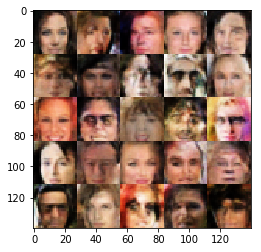

Epoch 7/10... Discriminator Loss: 3.5810... Generator Loss: 4.4633
Epoch 7/10... Discriminator Loss: 1.4596... Generator Loss: 1.0736
Epoch 7/10... Discriminator Loss: 1.4685... Generator Loss: 0.6851
Epoch 7/10... Discriminator Loss: 1.4818... Generator Loss: 0.5904
Epoch 7/10... Discriminator Loss: 1.4607... Generator Loss: 0.5587
Epoch 7/10... Discriminator Loss: 1.3405... Generator Loss: 0.7300
Epoch 7/10... Discriminator Loss: 1.2225... Generator Loss: 0.8827
Epoch 7/10... Discriminator Loss: 1.2431... Generator Loss: 0.6883
Epoch 7/10... Discriminator Loss: 1.0027... Generator Loss: 1.8940
Epoch 7/10... Discriminator Loss: 1.1589... Generator Loss: 2.0373


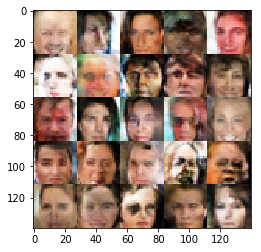

Epoch 7/10... Discriminator Loss: 1.2910... Generator Loss: 0.6190
Epoch 7/10... Discriminator Loss: 0.9565... Generator Loss: 1.3425
Epoch 7/10... Discriminator Loss: 0.9090... Generator Loss: 1.3136
Epoch 7/10... Discriminator Loss: 1.3258... Generator Loss: 0.5902
Epoch 7/10... Discriminator Loss: 0.7336... Generator Loss: 1.9076
Epoch 7/10... Discriminator Loss: 0.9092... Generator Loss: 1.8369
Epoch 7/10... Discriminator Loss: 0.9341... Generator Loss: 2.5899
Epoch 7/10... Discriminator Loss: 1.0592... Generator Loss: 0.9062
Epoch 7/10... Discriminator Loss: 0.7556... Generator Loss: 1.7639
Epoch 7/10... Discriminator Loss: 0.9726... Generator Loss: 0.9825


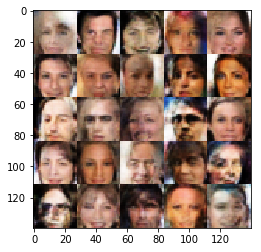

Epoch 7/10... Discriminator Loss: 1.6091... Generator Loss: 0.4566
Epoch 7/10... Discriminator Loss: 1.0624... Generator Loss: 0.9091
Epoch 7/10... Discriminator Loss: 0.8781... Generator Loss: 1.2719
Epoch 7/10... Discriminator Loss: 0.8494... Generator Loss: 1.8193
Epoch 7/10... Discriminator Loss: 0.9239... Generator Loss: 1.2452
Epoch 7/10... Discriminator Loss: 0.7046... Generator Loss: 2.5458
Epoch 7/10... Discriminator Loss: 1.2318... Generator Loss: 1.9714
Epoch 7/10... Discriminator Loss: 0.8529... Generator Loss: 1.6905
Epoch 7/10... Discriminator Loss: 1.1375... Generator Loss: 0.7199
Epoch 7/10... Discriminator Loss: 0.8667... Generator Loss: 1.6792


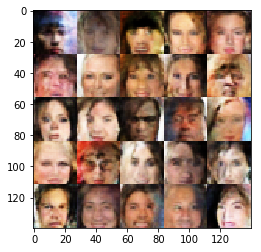

Epoch 7/10... Discriminator Loss: 0.8902... Generator Loss: 1.5467
Epoch 7/10... Discriminator Loss: 1.0416... Generator Loss: 0.8527
Epoch 7/10... Discriminator Loss: 0.7420... Generator Loss: 2.7324
Epoch 7/10... Discriminator Loss: 0.7800... Generator Loss: 1.9286
Epoch 7/10... Discriminator Loss: 1.8084... Generator Loss: 0.3573
Epoch 7/10... Discriminator Loss: 0.8747... Generator Loss: 1.8708
Epoch 7/10... Discriminator Loss: 0.9754... Generator Loss: 2.3818
Epoch 7/10... Discriminator Loss: 0.7794... Generator Loss: 1.5487
Epoch 7/10... Discriminator Loss: 0.7372... Generator Loss: 1.6132
Epoch 7/10... Discriminator Loss: 0.7398... Generator Loss: 2.7933


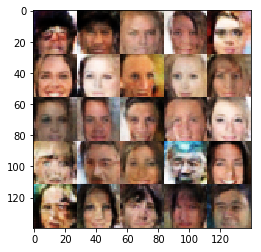

Epoch 7/10... Discriminator Loss: 1.5329... Generator Loss: 0.4378
Epoch 7/10... Discriminator Loss: 0.7398... Generator Loss: 2.7406
Epoch 7/10... Discriminator Loss: 0.7769... Generator Loss: 1.9768
Epoch 7/10... Discriminator Loss: 0.8284... Generator Loss: 1.3645
Epoch 7/10... Discriminator Loss: 0.6488... Generator Loss: 2.3473
Epoch 7/10... Discriminator Loss: 1.1948... Generator Loss: 0.7708
Epoch 7/10... Discriminator Loss: 1.3837... Generator Loss: 1.0884
Epoch 7/10... Discriminator Loss: 1.3711... Generator Loss: 0.7517
Epoch 7/10... Discriminator Loss: 1.4907... Generator Loss: 0.8185
Epoch 7/10... Discriminator Loss: 1.4864... Generator Loss: 0.9844


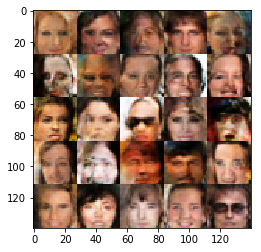

Epoch 7/10... Discriminator Loss: 1.4657... Generator Loss: 0.5798
Epoch 7/10... Discriminator Loss: 1.3925... Generator Loss: 1.0982
Epoch 7/10... Discriminator Loss: 1.3829... Generator Loss: 0.8870
Epoch 7/10... Discriminator Loss: 1.3409... Generator Loss: 0.7790
Epoch 7/10... Discriminator Loss: 1.3761... Generator Loss: 0.7910
Epoch 7/10... Discriminator Loss: 1.4453... Generator Loss: 1.2724
Epoch 7/10... Discriminator Loss: 1.3247... Generator Loss: 1.2829
Epoch 7/10... Discriminator Loss: 1.2369... Generator Loss: 1.7929
Epoch 7/10... Discriminator Loss: 1.6398... Generator Loss: 1.5897
Epoch 7/10... Discriminator Loss: 1.6459... Generator Loss: 0.4051


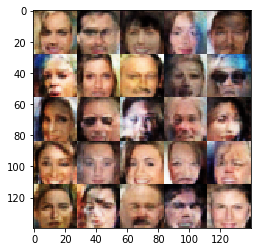

Epoch 7/10... Discriminator Loss: 1.3020... Generator Loss: 0.6859
Epoch 7/10... Discriminator Loss: 1.1304... Generator Loss: 0.8003
Epoch 7/10... Discriminator Loss: 1.1503... Generator Loss: 0.7835
Epoch 8/10... Discriminator Loss: 0.9352... Generator Loss: 1.7538
Epoch 8/10... Discriminator Loss: 0.7603... Generator Loss: 1.9739
Epoch 8/10... Discriminator Loss: 2.2912... Generator Loss: 3.0233
Epoch 8/10... Discriminator Loss: 1.1808... Generator Loss: 1.0897
Epoch 8/10... Discriminator Loss: 2.0798... Generator Loss: 0.3204
Epoch 8/10... Discriminator Loss: 1.4028... Generator Loss: 0.7091
Epoch 8/10... Discriminator Loss: 1.2889... Generator Loss: 0.8439


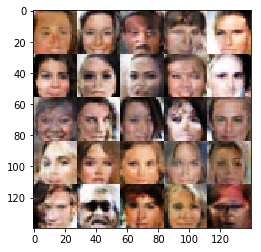

Epoch 8/10... Discriminator Loss: 1.3044... Generator Loss: 0.8779
Epoch 8/10... Discriminator Loss: 1.3222... Generator Loss: 0.9864
Epoch 8/10... Discriminator Loss: 1.2186... Generator Loss: 1.0151
Epoch 8/10... Discriminator Loss: 1.5596... Generator Loss: 0.4314
Epoch 8/10... Discriminator Loss: 1.0535... Generator Loss: 1.0453
Epoch 8/10... Discriminator Loss: 0.9309... Generator Loss: 1.3761
Epoch 8/10... Discriminator Loss: 0.8653... Generator Loss: 1.5683
Epoch 8/10... Discriminator Loss: 0.9734... Generator Loss: 1.0757
Epoch 8/10... Discriminator Loss: 0.9631... Generator Loss: 1.0028
Epoch 8/10... Discriminator Loss: 0.8279... Generator Loss: 1.5413


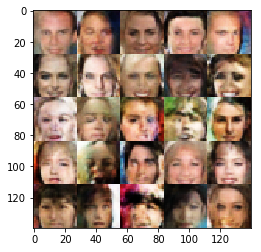

Epoch 8/10... Discriminator Loss: 0.7563... Generator Loss: 1.8743
Epoch 8/10... Discriminator Loss: 1.1356... Generator Loss: 0.7504
Epoch 8/10... Discriminator Loss: 2.0774... Generator Loss: 0.2728
Epoch 8/10... Discriminator Loss: 1.1177... Generator Loss: 0.9326
Epoch 8/10... Discriminator Loss: 1.0444... Generator Loss: 1.6319
Epoch 8/10... Discriminator Loss: 0.9474... Generator Loss: 1.0857
Epoch 8/10... Discriminator Loss: 1.0955... Generator Loss: 0.7886
Epoch 8/10... Discriminator Loss: 1.1402... Generator Loss: 0.7438
Epoch 8/10... Discriminator Loss: 1.2225... Generator Loss: 0.6830
Epoch 8/10... Discriminator Loss: 0.8954... Generator Loss: 1.3350


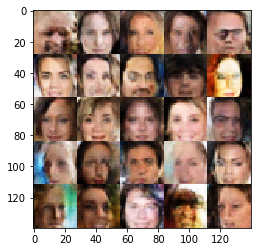

Epoch 8/10... Discriminator Loss: 1.1248... Generator Loss: 0.7670
Epoch 8/10... Discriminator Loss: 0.8371... Generator Loss: 1.4763
Epoch 8/10... Discriminator Loss: 0.8666... Generator Loss: 1.4892
Epoch 8/10... Discriminator Loss: 0.8116... Generator Loss: 1.6484
Epoch 8/10... Discriminator Loss: 1.0308... Generator Loss: 0.9164
Epoch 8/10... Discriminator Loss: 1.0983... Generator Loss: 0.8046
Epoch 8/10... Discriminator Loss: 1.3611... Generator Loss: 0.9465
Epoch 8/10... Discriminator Loss: 1.3654... Generator Loss: 1.4170
Epoch 8/10... Discriminator Loss: 1.2986... Generator Loss: 1.2317
Epoch 8/10... Discriminator Loss: 1.4947... Generator Loss: 2.0541


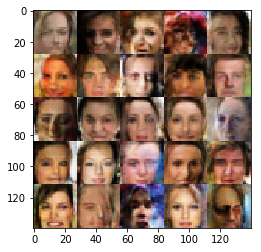

Epoch 8/10... Discriminator Loss: 1.1222... Generator Loss: 0.8059
Epoch 8/10... Discriminator Loss: 0.8732... Generator Loss: 1.5599
Epoch 8/10... Discriminator Loss: 1.0290... Generator Loss: 1.6733
Epoch 8/10... Discriminator Loss: 0.9871... Generator Loss: 0.9935
Epoch 8/10... Discriminator Loss: 0.8643... Generator Loss: 1.3015
Epoch 8/10... Discriminator Loss: 1.4692... Generator Loss: 0.4894
Epoch 8/10... Discriminator Loss: 1.2361... Generator Loss: 0.8011
Epoch 8/10... Discriminator Loss: 1.3080... Generator Loss: 1.5074
Epoch 8/10... Discriminator Loss: 0.9502... Generator Loss: 1.2636
Epoch 8/10... Discriminator Loss: 1.0498... Generator Loss: 0.8401


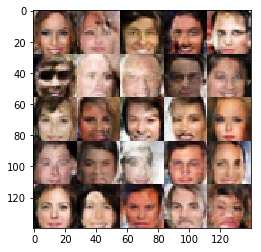

Epoch 8/10... Discriminator Loss: 0.7838... Generator Loss: 1.4692
Epoch 8/10... Discriminator Loss: 0.7882... Generator Loss: 1.6430
Epoch 8/10... Discriminator Loss: 0.7602... Generator Loss: 1.6244
Epoch 8/10... Discriminator Loss: 1.0896... Generator Loss: 0.7701
Epoch 8/10... Discriminator Loss: 1.0717... Generator Loss: 1.1521
Epoch 8/10... Discriminator Loss: 0.9819... Generator Loss: 1.1070
Epoch 8/10... Discriminator Loss: 0.9702... Generator Loss: 1.1895
Epoch 8/10... Discriminator Loss: 0.8580... Generator Loss: 2.5747
Epoch 8/10... Discriminator Loss: 0.9606... Generator Loss: 1.6253
Epoch 8/10... Discriminator Loss: 0.9972... Generator Loss: 1.8446


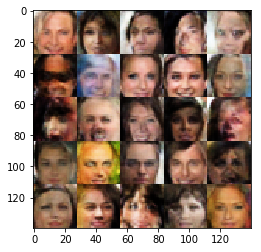

Epoch 8/10... Discriminator Loss: 1.2589... Generator Loss: 0.6285
Epoch 8/10... Discriminator Loss: 0.7613... Generator Loss: 1.5627
Epoch 8/10... Discriminator Loss: 0.9177... Generator Loss: 1.1906
Epoch 8/10... Discriminator Loss: 0.6530... Generator Loss: 1.7730
Epoch 8/10... Discriminator Loss: 0.6329... Generator Loss: 1.8849
Epoch 8/10... Discriminator Loss: 0.6837... Generator Loss: 1.7192
Epoch 8/10... Discriminator Loss: 0.6297... Generator Loss: 2.0048
Epoch 8/10... Discriminator Loss: 0.9007... Generator Loss: 1.7238
Epoch 8/10... Discriminator Loss: 2.1563... Generator Loss: 3.6880
Epoch 8/10... Discriminator Loss: 1.3816... Generator Loss: 0.5426


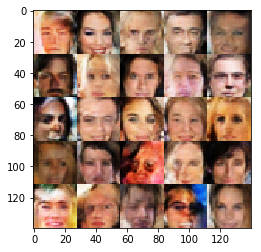

Epoch 8/10... Discriminator Loss: 1.1851... Generator Loss: 2.0916
Epoch 8/10... Discriminator Loss: 0.9579... Generator Loss: 2.1625
Epoch 8/10... Discriminator Loss: 1.2650... Generator Loss: 0.6484
Epoch 8/10... Discriminator Loss: 0.9969... Generator Loss: 1.6516
Epoch 8/10... Discriminator Loss: 1.0418... Generator Loss: 1.0854
Epoch 8/10... Discriminator Loss: 0.7472... Generator Loss: 2.0969
Epoch 8/10... Discriminator Loss: 1.3159... Generator Loss: 0.6146
Epoch 8/10... Discriminator Loss: 0.9354... Generator Loss: 1.2186
Epoch 8/10... Discriminator Loss: 1.1648... Generator Loss: 0.7580
Epoch 8/10... Discriminator Loss: 0.8932... Generator Loss: 1.2027


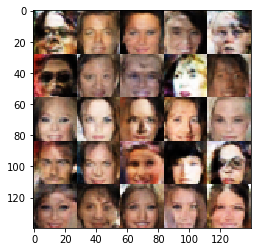

Epoch 8/10... Discriminator Loss: 0.9886... Generator Loss: 1.0237
Epoch 8/10... Discriminator Loss: 0.7947... Generator Loss: 1.7261
Epoch 9/10... Discriminator Loss: 0.7458... Generator Loss: 1.9444
Epoch 9/10... Discriminator Loss: 0.9728... Generator Loss: 0.9440
Epoch 9/10... Discriminator Loss: 0.9462... Generator Loss: 1.0443
Epoch 9/10... Discriminator Loss: 0.9287... Generator Loss: 1.1060
Epoch 9/10... Discriminator Loss: 0.6706... Generator Loss: 2.2808
Epoch 9/10... Discriminator Loss: 1.3152... Generator Loss: 1.7737
Epoch 9/10... Discriminator Loss: 1.0553... Generator Loss: 1.8404
Epoch 9/10... Discriminator Loss: 1.6408... Generator Loss: 2.6646


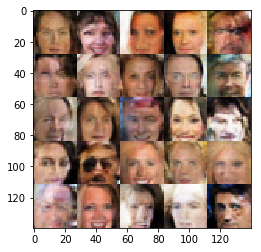

Epoch 9/10... Discriminator Loss: 0.8233... Generator Loss: 4.5273
Epoch 9/10... Discriminator Loss: 0.8340... Generator Loss: 1.2862
Epoch 9/10... Discriminator Loss: 0.9187... Generator Loss: 1.1049
Epoch 9/10... Discriminator Loss: 0.9789... Generator Loss: 0.9486
Epoch 9/10... Discriminator Loss: 0.8145... Generator Loss: 1.5072
Epoch 9/10... Discriminator Loss: 0.7848... Generator Loss: 1.5109
Epoch 9/10... Discriminator Loss: 0.7682... Generator Loss: 1.7873
Epoch 9/10... Discriminator Loss: 0.9171... Generator Loss: 2.1482
Epoch 9/10... Discriminator Loss: 0.7369... Generator Loss: 2.2196
Epoch 9/10... Discriminator Loss: 1.6522... Generator Loss: 2.8429


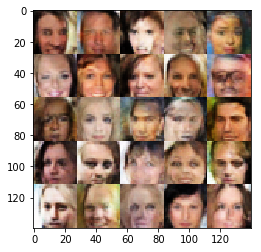

Epoch 9/10... Discriminator Loss: 0.8054... Generator Loss: 2.1263
Epoch 9/10... Discriminator Loss: 1.6115... Generator Loss: 2.8662
Epoch 9/10... Discriminator Loss: 0.9552... Generator Loss: 1.2605
Epoch 9/10... Discriminator Loss: 0.9981... Generator Loss: 0.9547
Epoch 9/10... Discriminator Loss: 1.0804... Generator Loss: 0.8316
Epoch 9/10... Discriminator Loss: 1.5298... Generator Loss: 0.4781
Epoch 9/10... Discriminator Loss: 1.0249... Generator Loss: 1.2921
Epoch 9/10... Discriminator Loss: 0.7954... Generator Loss: 1.8328
Epoch 9/10... Discriminator Loss: 1.1210... Generator Loss: 0.7742
Epoch 9/10... Discriminator Loss: 0.8501... Generator Loss: 1.3661


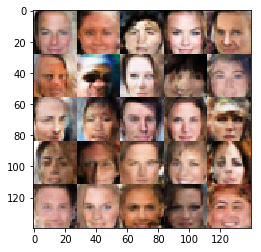

Epoch 9/10... Discriminator Loss: 3.0057... Generator Loss: 3.9616
Epoch 9/10... Discriminator Loss: 1.2868... Generator Loss: 0.8211
Epoch 9/10... Discriminator Loss: 1.3643... Generator Loss: 1.6639
Epoch 9/10... Discriminator Loss: 1.0883... Generator Loss: 1.3937
Epoch 9/10... Discriminator Loss: 0.8759... Generator Loss: 1.2550
Epoch 9/10... Discriminator Loss: 0.9195... Generator Loss: 1.2685
Epoch 9/10... Discriminator Loss: 0.9014... Generator Loss: 1.0768
Epoch 9/10... Discriminator Loss: 0.9847... Generator Loss: 0.9744
Epoch 9/10... Discriminator Loss: 0.9666... Generator Loss: 0.9527
Epoch 9/10... Discriminator Loss: 0.7431... Generator Loss: 1.7930


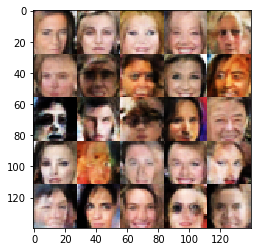

Epoch 9/10... Discriminator Loss: 1.5787... Generator Loss: 0.4292
Epoch 9/10... Discriminator Loss: 1.4965... Generator Loss: 1.2803
Epoch 9/10... Discriminator Loss: 1.0047... Generator Loss: 1.3338
Epoch 9/10... Discriminator Loss: 0.8608... Generator Loss: 1.4431
Epoch 9/10... Discriminator Loss: 0.9879... Generator Loss: 1.1799
Epoch 9/10... Discriminator Loss: 0.9562... Generator Loss: 2.2387
Epoch 9/10... Discriminator Loss: 0.9988... Generator Loss: 0.9210
Epoch 9/10... Discriminator Loss: 0.7227... Generator Loss: 2.1842
Epoch 9/10... Discriminator Loss: 0.7839... Generator Loss: 1.8981
Epoch 9/10... Discriminator Loss: 1.6654... Generator Loss: 2.6193


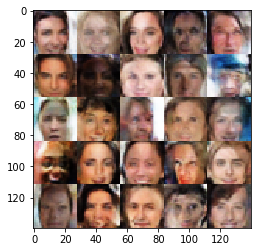

Epoch 9/10... Discriminator Loss: 1.1350... Generator Loss: 0.7785
Epoch 9/10... Discriminator Loss: 1.0716... Generator Loss: 0.8389
Epoch 9/10... Discriminator Loss: 1.1584... Generator Loss: 0.6857
Epoch 9/10... Discriminator Loss: 1.3095... Generator Loss: 0.5999
Epoch 9/10... Discriminator Loss: 1.4652... Generator Loss: 0.5870
Epoch 9/10... Discriminator Loss: 0.9856... Generator Loss: 1.4181
Epoch 9/10... Discriminator Loss: 1.0379... Generator Loss: 1.0039
Epoch 9/10... Discriminator Loss: 0.7721... Generator Loss: 1.5506
Epoch 9/10... Discriminator Loss: 1.0825... Generator Loss: 0.8412
Epoch 9/10... Discriminator Loss: 1.3228... Generator Loss: 0.5469


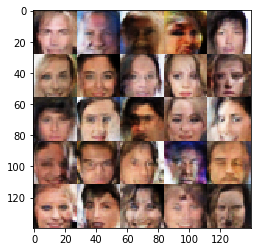

Epoch 9/10... Discriminator Loss: 0.8625... Generator Loss: 1.6788
Epoch 9/10... Discriminator Loss: 0.7297... Generator Loss: 2.0947
Epoch 9/10... Discriminator Loss: 0.3758... Generator Loss: 5.1673
Epoch 9/10... Discriminator Loss: 0.8405... Generator Loss: 1.4849
Epoch 9/10... Discriminator Loss: 0.8971... Generator Loss: 1.2011
Epoch 9/10... Discriminator Loss: 1.4368... Generator Loss: 0.5550
Epoch 9/10... Discriminator Loss: 1.4949... Generator Loss: 1.2322
Epoch 9/10... Discriminator Loss: 1.3329... Generator Loss: 0.6290
Epoch 9/10... Discriminator Loss: 0.9855... Generator Loss: 1.0011
Epoch 9/10... Discriminator Loss: 1.0118... Generator Loss: 1.9142


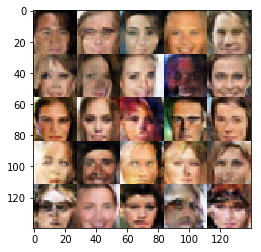

Epoch 9/10... Discriminator Loss: 0.9142... Generator Loss: 1.4835
Epoch 9/10... Discriminator Loss: 1.0381... Generator Loss: 0.8329
Epoch 9/10... Discriminator Loss: 0.7552... Generator Loss: 1.4532
Epoch 9/10... Discriminator Loss: 1.0289... Generator Loss: 1.1857
Epoch 9/10... Discriminator Loss: 2.3760... Generator Loss: 2.8585
Epoch 9/10... Discriminator Loss: 1.0486... Generator Loss: 1.4445
Epoch 9/10... Discriminator Loss: 1.3925... Generator Loss: 2.0155
Epoch 9/10... Discriminator Loss: 1.1208... Generator Loss: 2.3598
Epoch 9/10... Discriminator Loss: 0.9096... Generator Loss: 1.2131
Epoch 9/10... Discriminator Loss: 0.8731... Generator Loss: 1.3619


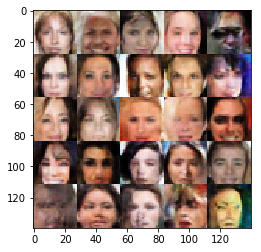

Epoch 9/10... Discriminator Loss: 1.0447... Generator Loss: 0.9139
Epoch 10/10... Discriminator Loss: 1.0736... Generator Loss: 0.8258
Epoch 10/10... Discriminator Loss: 1.4250... Generator Loss: 0.5099
Epoch 10/10... Discriminator Loss: 0.8287... Generator Loss: 1.5940
Epoch 10/10... Discriminator Loss: 0.7541... Generator Loss: 1.6706
Epoch 10/10... Discriminator Loss: 1.1733... Generator Loss: 0.6967
Epoch 10/10... Discriminator Loss: 1.0253... Generator Loss: 1.7642
Epoch 10/10... Discriminator Loss: 0.9908... Generator Loss: 0.9657
Epoch 10/10... Discriminator Loss: 0.8437... Generator Loss: 1.2555
Epoch 10/10... Discriminator Loss: 0.7525... Generator Loss: 2.0425


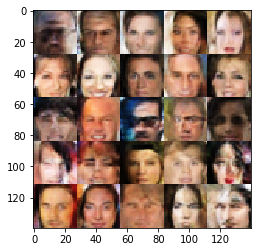

Epoch 10/10... Discriminator Loss: 2.0172... Generator Loss: 2.7029
Epoch 10/10... Discriminator Loss: 1.2222... Generator Loss: 1.2375
Epoch 10/10... Discriminator Loss: 1.1361... Generator Loss: 1.7313
Epoch 10/10... Discriminator Loss: 1.0885... Generator Loss: 0.8568
Epoch 10/10... Discriminator Loss: 1.3008... Generator Loss: 0.6490
Epoch 10/10... Discriminator Loss: 0.9048... Generator Loss: 1.2589
Epoch 10/10... Discriminator Loss: 1.1684... Generator Loss: 0.7300
Epoch 10/10... Discriminator Loss: 1.1788... Generator Loss: 0.7084
Epoch 10/10... Discriminator Loss: 0.8445... Generator Loss: 1.5842
Epoch 10/10... Discriminator Loss: 0.6649... Generator Loss: 1.9567


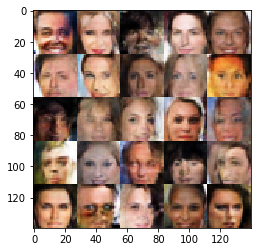

Epoch 10/10... Discriminator Loss: 0.9420... Generator Loss: 1.8481
Epoch 10/10... Discriminator Loss: 0.8568... Generator Loss: 1.1492
Epoch 10/10... Discriminator Loss: 0.7964... Generator Loss: 1.4593
Epoch 10/10... Discriminator Loss: 1.7965... Generator Loss: 2.2457
Epoch 10/10... Discriminator Loss: 0.9483... Generator Loss: 1.0515
Epoch 10/10... Discriminator Loss: 0.7701... Generator Loss: 1.7657
Epoch 10/10... Discriminator Loss: 1.0103... Generator Loss: 0.8747
Epoch 10/10... Discriminator Loss: 0.9762... Generator Loss: 1.2417
Epoch 10/10... Discriminator Loss: 0.7897... Generator Loss: 1.6364
Epoch 10/10... Discriminator Loss: 1.3881... Generator Loss: 0.6480


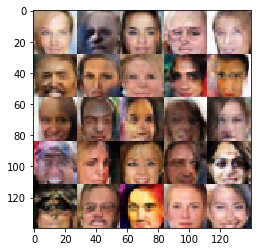

Epoch 10/10... Discriminator Loss: 1.1473... Generator Loss: 0.8351
Epoch 10/10... Discriminator Loss: 1.5202... Generator Loss: 0.4796
Epoch 10/10... Discriminator Loss: 0.9689... Generator Loss: 1.7510
Epoch 10/10... Discriminator Loss: 1.4957... Generator Loss: 0.4753
Epoch 10/10... Discriminator Loss: 0.8187... Generator Loss: 1.3421
Epoch 10/10... Discriminator Loss: 0.7094... Generator Loss: 1.8826
Epoch 10/10... Discriminator Loss: 0.8170... Generator Loss: 1.2037
Epoch 10/10... Discriminator Loss: 1.3795... Generator Loss: 3.1468
Epoch 10/10... Discriminator Loss: 1.2473... Generator Loss: 1.2572
Epoch 10/10... Discriminator Loss: 1.3696... Generator Loss: 1.2729


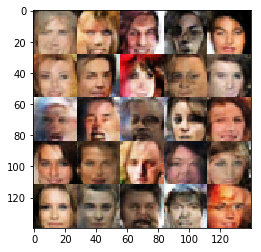

Epoch 10/10... Discriminator Loss: 1.1839... Generator Loss: 1.3733
Epoch 10/10... Discriminator Loss: 1.3780... Generator Loss: 0.6569
Epoch 10/10... Discriminator Loss: 1.3209... Generator Loss: 0.6265
Epoch 10/10... Discriminator Loss: 1.2824... Generator Loss: 0.6547
Epoch 10/10... Discriminator Loss: 0.8928... Generator Loss: 1.1832
Epoch 10/10... Discriminator Loss: 0.8367... Generator Loss: 1.9357
Epoch 10/10... Discriminator Loss: 0.7440... Generator Loss: 1.9375
Epoch 10/10... Discriminator Loss: 1.0248... Generator Loss: 1.7469
Epoch 10/10... Discriminator Loss: 0.9055... Generator Loss: 1.6740
Epoch 10/10... Discriminator Loss: 1.0442... Generator Loss: 0.8513


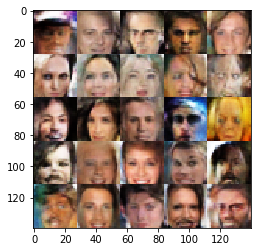

Epoch 10/10... Discriminator Loss: 0.7807... Generator Loss: 1.6356
Epoch 10/10... Discriminator Loss: 0.9563... Generator Loss: 2.1831
Epoch 10/10... Discriminator Loss: 0.7369... Generator Loss: 1.4952
Epoch 10/10... Discriminator Loss: 1.0350... Generator Loss: 0.8719
Epoch 10/10... Discriminator Loss: 0.8050... Generator Loss: 1.8165
Epoch 10/10... Discriminator Loss: 0.7861... Generator Loss: 1.4748
Epoch 10/10... Discriminator Loss: 1.2326... Generator Loss: 0.6672
Epoch 10/10... Discriminator Loss: 1.6864... Generator Loss: 1.3350
Epoch 10/10... Discriminator Loss: 0.9897... Generator Loss: 1.3809
Epoch 10/10... Discriminator Loss: 1.6124... Generator Loss: 2.5741


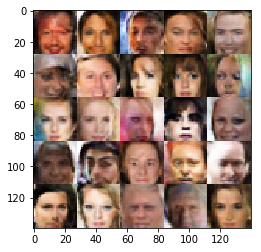

Epoch 10/10... Discriminator Loss: 0.9754... Generator Loss: 1.4710
Epoch 10/10... Discriminator Loss: 1.2608... Generator Loss: 0.6400
Epoch 10/10... Discriminator Loss: 1.0379... Generator Loss: 0.9786
Epoch 10/10... Discriminator Loss: 0.8088... Generator Loss: 1.4638
Epoch 10/10... Discriminator Loss: 0.8908... Generator Loss: 1.3787
Epoch 10/10... Discriminator Loss: 0.9545... Generator Loss: 1.7861
Epoch 10/10... Discriminator Loss: 0.7995... Generator Loss: 1.4462
Epoch 10/10... Discriminator Loss: 0.8437... Generator Loss: 1.6652
Epoch 10/10... Discriminator Loss: 0.7991... Generator Loss: 1.3702
Epoch 10/10... Discriminator Loss: 1.5946... Generator Loss: 2.5840


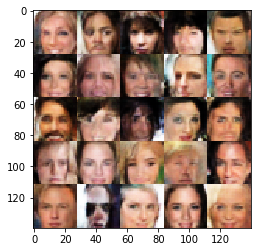

Epoch 10/10... Discriminator Loss: 1.1613... Generator Loss: 0.7825
Epoch 10/10... Discriminator Loss: 1.1057... Generator Loss: 0.8192
Epoch 10/10... Discriminator Loss: 1.1130... Generator Loss: 0.7944
Epoch 10/10... Discriminator Loss: 0.9904... Generator Loss: 1.1381
Epoch 10/10... Discriminator Loss: 0.9953... Generator Loss: 0.9428
Epoch 10/10... Discriminator Loss: 1.3365... Generator Loss: 0.5767
Epoch 10/10... Discriminator Loss: 1.0710... Generator Loss: 0.8637
Epoch 10/10... Discriminator Loss: 0.8201... Generator Loss: 1.7769
Epoch 10/10... Discriminator Loss: 0.7436... Generator Loss: 1.8148
Epoch 10/10... Discriminator Loss: 0.8593... Generator Loss: 1.2040


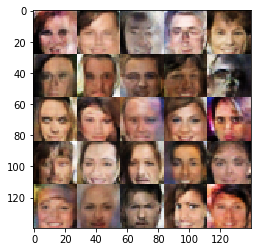

Epoch 10/10... Discriminator Loss: 0.8159... Generator Loss: 1.4158


In [26]:
batch_size = 256
z_dim = 200
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 10

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### 提交项目
提交本项目前，确保运行所有 cells 后保存该文件。

保存该文件为 "dlnd_face_generation.ipynb"， 并另存为 HTML 格式 "File" -> "Download as"。提交项目时请附带 "helper.py" 和 "problem_unittests.py" 文件。